In [1]:
library("tidyverse")
library("cowplot")
library("data.table")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘data.table’


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




# Numbers check

## Overall mean sample correlation original dataset

In [2]:
df <- fread(
    "/nfs/research/birney/users/saul/outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_stitch_downsampling_snps/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz",
    header = FALSE,
    col.names = c("sample", "gt_r2", "ds_r2")
)

In [3]:
df[, mean(ds_r2)]

[1] 0.996314

## Rare MAF bin correlation original dataset

In [4]:
df <- fread(
    "/nfs/research/birney/users/saul/outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_stitch_downsampling_snps/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz",
    header = FALSE,
    col.names = c("row_id", "n_genotypes", "mean_AF", "gt_r2", "ds_r2")
)

In [5]:
df[mean_AF == min(mean_AF), ds_r2]

[1] 0.977261

## Number of samples overall and good

In [6]:
df <- fread(
    "/nfs/research/birney/users/saul/meta/heart_rate_tmp/stitchimpute/samplesheet_f1_f2_good_samples.csv"
)

nrow(df)

[1] 2177

In [7]:
df <- fread(
    "/nfs/research/birney/users/saul/meta/heart_rate_tmp/stitchimpute/samplesheet_f1_f2.csv"
)

nrow(df)

[1] 2219

In [12]:
meta <- fread(
    "zstdcat /nfs/research/birney/users/saul/meta/heart_rate_tmp/processed/linked_meta_sequencing_sarek_phenotypes.csv.zst"
)

In [13]:
meta[medaka_type %in% c("F1", "F2") & mean_depth > 0.1, .N]

[1] 2177

## Number of samples in sigle cross

In [14]:
meta[medaka_type %in% c("F1", "F2") & mean_depth > 0.1 & cross_id == "72-2x55-2", .N]

[1] 474

## Performance sigle cross

In [15]:
df <- fread(
    "/nfs/research/birney/users/saul/outputs/heart_rate_tmp/stitch_downsampling/downsample_crosses/no_22-1_68-1_79-2_15-1_62-2_139-4/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz",
    header = FALSE,
    col.names = c("row_id", "n_genotypes", "mean_AF", "gt_r2", "ds_r2")
)

df[order(ds_r2), .(mean_AF, ds_r2, n_genotypes)]

mean_AF,ds_r2,n_genotypes
<dbl>,<dbl>,<int>
0.00213771,0.694043,4342208
0.07072500,0.964320,337879
0.12694300,0.971872,287345
0.42718900,0.977001,691393
0.47684800,0.978708,1220847
0.17571500,0.980740,403224
0.22496400,0.980770,467089
0.37542500,0.981339,447919
0.32446700,0.982381,451034


## Performance 500 samples

In [16]:
df <- fread(
    "/nfs/research/birney/users/saul/outputs/heart_rate_tmp/stitch_downsampling/500_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz",
    header = FALSE,
    col.names = c("row_id", "n_genotypes", "mean_AF", "gt_r2", "ds_r2")
)

df[order(ds_r2), .(mean_AF, ds_r2, n_genotypes)]

df[, range(ds_r2)]

mean_AF,ds_r2,n_genotypes
<dbl>,<dbl>,<int>
0.0272661,0.777079,5731552
0.0731064,0.901680,5720964
0.3248740,0.906018,2910348
0.4243650,0.906632,2588584
0.3744500,0.908009,2796223
0.4749590,0.908063,2439938
0.2742490,0.908719,2963982
0.1241650,0.909401,4236543
0.2237980,0.912064,3223796


[1] 0.777079 0.915300

## Performance overall coverage levels

In [17]:
setwd("/nfs/research/birney/users/saul/outputs/heart_rate_tmp/stitch_downsampling")

In [18]:
read_overall <- function(filename, ...){
    df <- fread(
        filename,
        header = FALSE,
        col.names = c("sample", "gt_r2", "ds_r2")
    )

    df <- df[
        , .(
            gt_r2 = mean(gt_r2, na.rm = TRUE),
            ds_r2 = mean(ds_r2, na.rm = TRUE)
        )
    ]
    
    add_cols <- list(...)
    add_cols_names <- names(add_cols)
    
    lapply(
        add_cols_names,
        function(col_name){
            set(df, j = col_name, value = add_cols[[col_name]])
        }
    )
    
    return(df)
}

In [19]:
files <- list(
    list(
        cov = "Original",
        n_samples = "Original",
        filename = "../f1_f2/stitchimpute/K16_nGen2_downsampled_truth_stitch_downsampling_snps/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "1x",
        n_samples = "Original",
        filename = "all_samples/cov_1x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.5x",
        n_samples = "Original",
        filename = "all_samples/cov_0.5x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.25x",
        n_samples = "Original",
        filename = "all_samples/cov_0.25x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.2x",
        n_samples = "Original",
        filename = "all_samples/cov_0.2x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.1x",
        n_samples = "Original",
        filename = "all_samples/cov_0.1x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "Original",
        n_samples = "1500",
        filename = "1500_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "Original",
        n_samples = "1000",
        filename = "1000_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "Original",
        n_samples = "500",
        filename = "500_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "Original",
        n_samples = "250",
        filename = "250_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    )
)

In [20]:
df <- lapply(files, function(...){ do.call("read_overall", ...) } ) |> rbindlist()

In [21]:
df

gt_r2,ds_r2,cov,n_samples
<dbl>,<dbl>,<chr>,<chr>
0.9963593,0.9963140,Original,Original
0.9922906,0.9922313,1x,Original
0.9806748,0.9806542,0.5x,Original
0.9449391,0.9450707,0.25x,Original
0.9240457,0.9242859,0.2x,Original
0.8105186,0.8113531,0.1x,Original
0.9926711,0.9926552,Original,1500
0.9845029,0.9845297,Original,1000
0.9580697,0.9582401,Original,500


In [22]:
get_cost <- function(
    n_samples,
    mean_depth,
    genome_size = 734040372, # medaka genome size obtained by summing ENSEMBL HdR-R reference chromosome lengths
    flowcell_output_bp = 273542732637, # observed median output after mapping and deduplication for P3 flowcells
    unitary_flowcell_cost_eur = 6155, # for the Illumina P3 at GeneCore EMBL HD
    unitary_library_prep_cost_eur = 9 # GeneCore EMBL HD
){
    bp_to_be_sequenced <- n_samples * mean_depth * genome_size
    sequencing_cost_eur <- (bp_to_be_sequenced / flowcell_output_bp) * unitary_flowcell_cost_eur
    library_prep_cost_eur <- n_samples * unitary_library_prep_cost_eur
    
    total_cost_eur <- library_prep_cost_eur + sequencing_cost_eur
    
    return(total_cost_eur)
}

In [23]:
df[, cov := fct_relevel(cov, rev(c("0.1x", "0.2x", "0.25x", "0.5x", "1x", "Original")))]
df[, n_samples := fct_relevel(n_samples, rev(c("250", "500", "1000", "1500", "Original")))]
df[, cov_num := ifelse(cov == "Original", 1.40072214091718, as.numeric(str_remove(cov, "x")))] # original coverage is the mean for low-coverage samples
df[, n_samples_num := ifelse(n_samples == "Original", 2219, as.numeric(as.character(n_samples)))]  # original number of samples include f2 low coverage, f2 high coverage, and f1

df[, cost := get_cost(n_samples_num, cov_num)]
df[, cost_human := get_cost(n_samples_num, cov_num, genome_size = 1e10)] # from https://www.science.org/doi/10.1126/science.abj6987#sec-2
orig_cost <- df[cov == "Original" & n_samples == "Original", cost]
orig_cost_human <- df[cov == "Original" & n_samples == "Original", cost_human]
df[, rel_cost := cost / orig_cost]
df[, rel_cost_human := cost_human / orig_cost_human]

df

Warning message in ifelse(cov == "Original", 1.40072214091718, as.numeric(str_remove(cov, :
“NAs introduced by coercion”
Warning message in ifelse(n_samples == "Original", 2219, as.numeric(as.character(n_samples))):
“NAs introduced by coercion”


gt_r2,ds_r2,cov,n_samples,cov_num,n_samples_num,cost,cost_human,rel_cost,rel_cost_human
<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.9963593,0.9963140,Original,Original,1.400722,2219,71308.193,719349.33,1.0000000,1.00000000
0.9922906,0.9922313,1x,Original,1.000000,2219,56621.519,519269.40,0.7940395,0.72185986
0.9806748,0.9806542,0.5x,Original,0.500000,2219,38296.259,269620.20,0.5370527,0.37481122
0.9449391,0.9450707,0.25x,Original,0.250000,2219,29133.630,144795.60,0.4085594,0.20128691
0.9240457,0.9242859,0.2x,Original,0.200000,2219,27301.104,119830.68,0.3828607,0.16658204
0.8105186,0.8113531,0.1x,Original,0.100000,2219,23636.052,69900.84,0.3314633,0.09717232
0.9926711,0.9926552,Original,1500,1.400722,1500,48202.924,486265.88,0.6759802,0.67598017
0.9845029,0.9845297,Original,1000,1.400722,1000,32135.283,324177.26,0.4506534,0.45065345
0.9580697,0.9582401,Original,500,1.400722,500,16067.641,162088.63,0.2253267,0.22532672


## Number of SNPs

In [24]:
setwd("/nfs/research/birney/users/saul/outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement")

In [25]:
inputs <- list(
    list(file = "iteration_1/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz", iteration = 1),
    list(file = "iteration_2/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz", iteration = 2),
    list(file = "iteration_3/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz", iteration = 3),
    list(file = "iteration_4/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz", iteration = 4),
    list(file = "iteration_5/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz", iteration = 5)
)

In [26]:
read_file <- function(file, iteration){
    read_tsv(file) %>%
    filter(!is.na(ds_r2)) %>%
    arrange(ds_r2) %>%
    mutate(n = row_number(), iteration = iteration)
}

In [27]:
df <- lapply(inputs, function(...){ do.call(read_file, ...) }) %>% bind_rows()

Rows: 6419045 Columns: 9
── Column specification ───────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): rsid, old_rsid, allele1, allele2
dbl (4): chr, pos, info, ds_r2
lgl (1): maf

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3875293 Columns: 9
── Column specification ───────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): rsid, old_rsid, allele1, allele2
dbl (4): chr, pos, info, ds_r2
lgl (1): maf

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3591684 Columns: 9
── Column specification ───────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): rsid, old_rsid, allele1, allele2
dbl (4): chr, pos

In [28]:
head(df)

chr,pos,rsid,old_rsid,allele1,allele2,maf,info,ds_r2,n,iteration
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<int>,<dbl>
1,8540,.,.,A,C,NA,0.00031,0,1,1
1,8664,.,.,T,A,NA,0.14319,0,2,1
1,12989,.,.,T,G,NA,0.00019,0,3,1
1,13217,.,.,A,C,NA,0.00078,0,4,1
1,13234,.,.,A,C,NA,0.00083,0,5,1
1,13314,.,.,G,T,NA,0.00040,0,6,1


In [29]:
df_summary_snp <- df %>% group_by(iteration) %>% summarise(n = n(), mean_r2_snp = mean(ds_r2, na.rm = TRUE))

df_summary_snp

iteration,n,mean_r2_snp
<dbl>,<int>,<dbl>
1,6187085,0.6336094
2,3844646,0.9224966
3,3583151,0.9662011
4,3408004,0.9829885
5,3203726,0.9915332


In [30]:
fread("/nfs/research/birney/users/saul/meta/heart_rate_tmp/stitchimpute/snp_filtering_criteria.csv")

V1
<dbl>
0.50
0.50
0.75
0.90
0.90


# Figure 2 - SNP set refinement and parameter optimisation

## SNP set refinement

In [31]:
setwd("/nfs/research/birney/users/saul/outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement")

In [32]:
inputs <- list(
    list(file = "iteration_1/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz", iteration = 1),
    list(file = "iteration_2/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz", iteration = 2),
    list(file = "iteration_3/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz", iteration = 3),
    list(file = "iteration_4/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz", iteration = 4),
    list(file = "iteration_5/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz", iteration = 5)
)

In [33]:
read_file <- function(file, iteration){
    read_tsv(file) %>%
    filter(!is.na(ds_r2)) %>%
    arrange(ds_r2) %>%
    mutate(n = row_number(), iteration = iteration)
}

In [34]:
df <- lapply(inputs, function(...){ do.call(read_file, ...) }) %>% bind_rows()

Rows: 6419045 Columns: 9
── Column specification ───────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): rsid, old_rsid, allele1, allele2
dbl (4): chr, pos, info, ds_r2
lgl (1): maf

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3875293 Columns: 9
── Column specification ───────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): rsid, old_rsid, allele1, allele2
dbl (4): chr, pos, info, ds_r2
lgl (1): maf

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3591684 Columns: 9
── Column specification ───────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): rsid, old_rsid, allele1, allele2
dbl (4): chr, pos

In [35]:
head(df)

chr,pos,rsid,old_rsid,allele1,allele2,maf,info,ds_r2,n,iteration
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<dbl>,<int>,<dbl>
1,8540,.,.,A,C,NA,0.00031,0,1,1
1,8664,.,.,T,A,NA,0.14319,0,2,1
1,12989,.,.,T,G,NA,0.00019,0,3,1
1,13217,.,.,A,C,NA,0.00078,0,4,1
1,13234,.,.,A,C,NA,0.00083,0,5,1
1,13314,.,.,G,T,NA,0.00040,0,6,1


In [36]:
df_summary_snp <- df %>% group_by(iteration) %>% summarise(n = n(), mean_r2_snp = mean(ds_r2, na.rm = TRUE))

df_summary_snp

iteration,n,mean_r2_snp
<dbl>,<int>,<dbl>
1,6187085,0.6336094
2,3844646,0.9224966
3,3583151,0.9662011
4,3408004,0.9829885
5,3203726,0.9915332


In [37]:
inputs_spl <- list(
    list(file = "iteration_1/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", iteration = 1),
    list(file = "iteration_2/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", iteration = 2),
    list(file = "iteration_3/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", iteration = 3),
    list(file = "iteration_4/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", iteration = 4),
    list(file = "iteration_5/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", iteration = 5)
)

In [38]:
read_spl <- function(file, iteration){
    read_delim(file, col_names = c("sample", "gt_r2", "ds_r2")) %>%
    mutate(iteration = iteration)
}

In [39]:
df_spl <- lapply(inputs_spl, function(...){ do.call(read_spl, ...) }) %>% bind_rows()

Rows: 12 Columns: 3
── Column specification ───────────────────────────────────────────────────────────────────────────────────────
Delimiter: " "
chr (1): sample
dbl (2): gt_r2, ds_r2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 12 Columns: 3
── Column specification ───────────────────────────────────────────────────────────────────────────────────────
Delimiter: " "
chr (1): sample
dbl (2): gt_r2, ds_r2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 12 Columns: 3
── Column specification ───────────────────────────────────────────────────────────────────────────────────────
Delimiter: " "
chr (1): sample
dbl (2): gt_r2, ds_r2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to 

In [40]:
df_summary <- df_spl %>%
group_by(iteration) %>%
summarise(mean_r2_spl = mean(ds_r2, na.rm = TRUE)) %>%
merge(df_summary_snp, by = "iteration")

df_summary

iteration,mean_r2_spl,n,mean_r2_snp
<dbl>,<dbl>,<int>,<dbl>
1,0.8775282,6187085,0.6336094
2,0.9725657,3844646,0.9224966
3,0.9832992,3583151,0.9662011
4,0.9900691,3408004,0.9829885
5,0.9956037,3203726,0.9915332


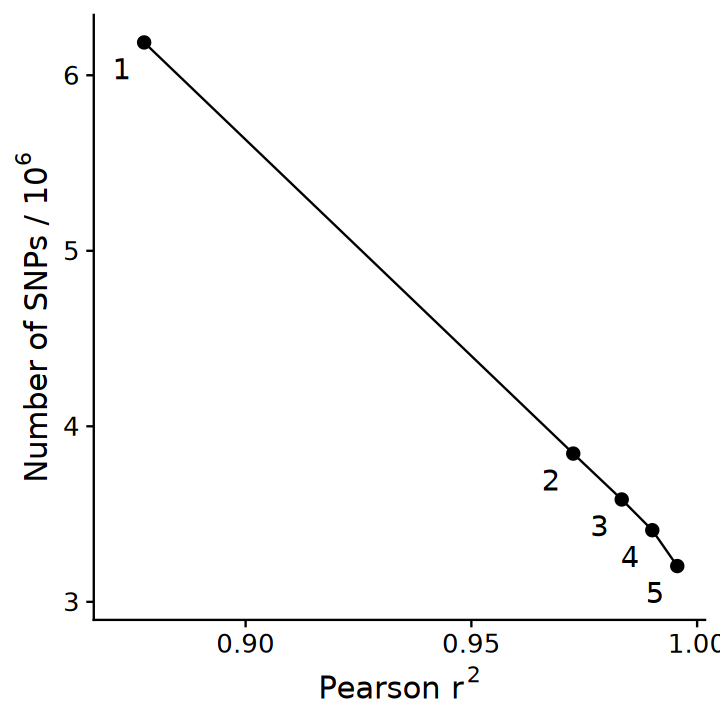

In [41]:
options(repr.plot.width = 6, repr.plot.height = 6)

p1 <- ggplot(df_summary, aes(y = n/1e6, x = mean_r2_spl, label = iteration)) +
    geom_point(size = 3) +
    geom_line() +
    geom_text(size = 6, nudge_x = -0.005, nudge_y = -0.15) +
    theme_cowplot(18) +
    labs(y = bquote("Number of SNPs /"~10^6), x = bquote("Pearson"~italic(r^2)))

p1

## Parameter optimisation

In [42]:
setwd("/nfs/research/birney/users/saul/outputs/heart_rate_tmp/f1_f2/stitchimpute/iteration_5_filtered_snps_downsampled_truth_param_optimisation")

In [43]:
inputs_spl <- list(
    list(file = "K_8_nGen_1/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", K = 8, nGen = 1),
    list(file = "K_8_nGen_2/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", K = 8, nGen = 2),
    list(file = "K_8_nGen_4/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", K = 8, nGen = 4),
    list(file = "K_8_nGen_10/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", K = 8, nGen = 10),
    list(file = "K_16_nGen_1/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", K = 16, nGen = 1),
    list(file = "K_16_nGen_2/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", K = 16, nGen = 2),
    list(file = "K_16_nGen_4/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", K = 16, nGen = 4),
    list(file = "K_16_nGen_10/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", K = 16, nGen = 10),
    list(file = "K_24_nGen_1/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", K = 24, nGen = 1),
    list(file = "K_24_nGen_2/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", K = 24, nGen = 2),
    list(file = "K_24_nGen_4/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", K = 24, nGen = 4),
    list(file = "K_24_nGen_10/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz", K = 24, nGen = 10)
)

In [44]:
read_spl <- function(file, K, nGen){
    read_delim(file, col_names = c("sample", "gt_r2", "ds_r2")) %>%
    mutate(K = K, nGen = nGen, group = sprintf("K%s_nGen%s", K, nGen))
}

In [45]:
df_spl_params <- lapply(inputs_spl, function(...){ do.call(read_spl, ...) }) %>% bind_rows()

Rows: 12 Columns: 3
── Column specification ───────────────────────────────────────────────────────────────────────────────────────
Delimiter: " "
chr (1): sample
dbl (2): gt_r2, ds_r2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 12 Columns: 3
── Column specification ───────────────────────────────────────────────────────────────────────────────────────
Delimiter: " "
chr (1): sample
dbl (2): gt_r2, ds_r2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 12 Columns: 3
── Column specification ───────────────────────────────────────────────────────────────────────────────────────
Delimiter: " "
chr (1): sample
dbl (2): gt_r2, ds_r2

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to 

In [46]:
head(df_spl_params)

sample,gt_r2,ds_r2,K,nGen,group
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
AAAKNVNHV_F1_Sample2_9542_21s005418-1-1_Welz_lane121s005418_AAAKNVNHV_F1_Sample2_9542_21s005418-1-1_Welz_lane121s005418,0.985704,0.986208,8,1,K8_nGen1
AAAKNVNHV_F1_Sample14_9550_21s005424-1-1_Welz_lane121s005424_AAAKNVNHV_F1_Sample14_9550_21s005424-1-1_Welz_lane121s005424,0.962424,0.963837,8,1,K8_nGen1
AAAKNVNHV_F1_Sample12_9547_21s005423-1-1_Welz_lane121s005423_AAAKNVNHV_F1_Sample12_9547_21s005423-1-1_Welz_lane121s005423,0.987040,0.987493,8,1,K8_nGen1
AAAKNVNHV_F1_Sample16_9551_21s005425-1-1_Welz_lane121s005425_AAAKNVNHV_F1_Sample16_9551_21s005425-1-1_Welz_lane121s005425,0.985127,0.985710,8,1,K8_nGen1
AAAKNVNHV_F1_Sample6_9544_21s005420-1-1_Welz_lane121s005420_AAAKNVNHV_F1_Sample6_9544_21s005420-1-1_Welz_lane121s005420,0.994980,0.995006,8,1,K8_nGen1
AAAKNVNHV_F1_Sample22_9631_21s005427-1-1_Welz_lane121s005427_AAAKNVNHV_F1_Sample22_9631_21s005427-1-1_Welz_lane121s005427,0.955088,0.956900,8,1,K8_nGen1


In [47]:
df_summary_params <- df_spl_params %>%
    group_by(group, K, nGen) %>%
    summarise(ds_r2 = mean(ds_r2, na.rm = TRUE)) %>%
    arrange(K, nGen) %>%
    ungroup() %>%
    mutate(
        the_order = row_number(),
        K_space = ifelse(nchar(K) == max(nchar(K)), "", sapply(max(nchar(K)) - nchar(K), function(nc){paste(rep(" ", nc), collapse = "")})),
        nGen_space = ifelse(nchar(nGen) == max(nchar(nGen)), "", sapply(max(nchar(nGen)) - nchar(nGen), function(nc){paste(rep(" ", nc), collapse = "")})),
        label = sprintf("K = %s%s, nGen = %s%s", K_space, K, nGen_space, nGen)
    ) %>%
    mutate(label = fct_reorder(label, -the_order))

df_summary_params

`summarise()` has grouped output by 'group', 'K'. You can override using the `.groups` argument.


group,K,nGen,ds_r2,the_order,K_space,nGen_space,label
<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<chr>,<fct>
K8_nGen1,8,1,0.9825943,1,,,"K = 8, nGen = 1"
K8_nGen2,8,2,0.9830617,2,,,"K = 8, nGen = 2"
K8_nGen4,8,4,0.9834678,3,,,"K = 8, nGen = 4"
K8_nGen10,8,10,0.9838558,4,,,"K = 8, nGen = 10"
K16_nGen1,16,1,0.9962893,5,,,"K = 16, nGen = 1"
K16_nGen2,16,2,0.9961412,6,,,"K = 16, nGen = 2"
K16_nGen4,16,4,0.9961477,7,,,"K = 16, nGen = 4"
K16_nGen10,16,10,0.9961291,8,,,"K = 16, nGen = 10"
K24_nGen1,24,1,0.9930512,9,,,"K = 24, nGen = 1"


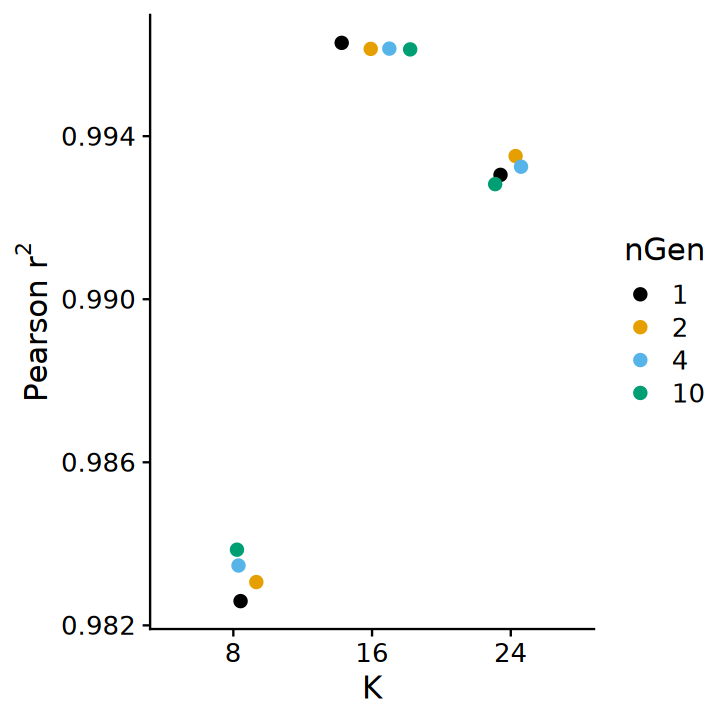

In [48]:
options(repr.plot.width = 6, repr.plot.height = 6)

p2 <- ggplot(df_summary_params, aes(y = ds_r2, x = as.factor(K), color = as.factor(nGen))) +
    geom_jitter(size = 3, width = 0.3, height = 0) +
    theme_cowplot(18) +
    labs(y =  bquote("Pearson"~r^2), x = "K", color = "nGen") +
    scale_color_manual(values = c("black", "#E69F00", "#56B4E9", "#009E73"))

p2

## Joint plot

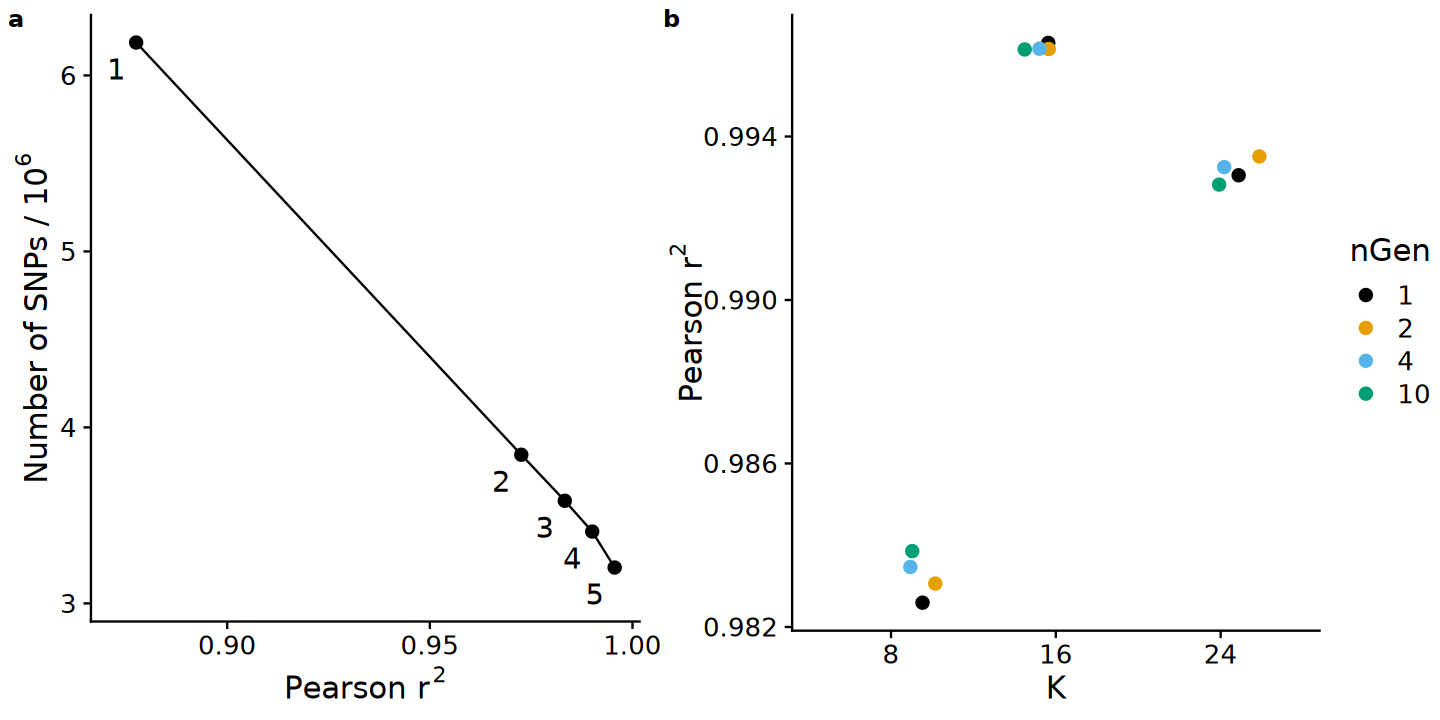

In [49]:
options(repr.plot.width = 12, repr.plot.height = 6)

figure_2 <- plot_grid(p1, p2, nrow = 1, labels = "auto", rel_widths = c(1, 1.2))

figure_2

In [50]:
ggsave(
    "/nfs/research/birney/users/saul/outputs/heart_rate_tmp/stitch_downsampling/draft_figures/figure_2_snp_set_refinement_param_optimisation.pdf",
    figure_2,
    width = 12,
    height = 6
)

# Figure 3 - Single axis downsampling performance

In [2]:
setwd("/nfs/research/birney/users/saul/outputs/heart_rate_tmp/stitch_downsampling")

In [3]:
read_maf_bins <- function(filename, ...){
    df <- fread(
        filename,
        header = FALSE,
        col.names = c("row_id", "n_genotypes", "mean_AF", "gt_r2", "ds_r2")
    )

    df[, row_id := NULL]

    add_cols <- list(...)
    add_cols_names <- names(add_cols)
    
    lapply(
        add_cols_names,
        function(col_name){
            set(df, j = col_name, value = add_cols[[col_name]])
        }
    )

    return(df)
}

In [8]:
files <- list(
    list(
        group = "Original",
        downsample_type = NA,
        filename = "../f1_f2/stitchimpute/K16_nGen2_downsampled_truth_stitch_downsampling_snps/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "1x",
        downsample_type = "Coverage",
        filename = "all_samples/cov_1x/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "0.5x",
        downsample_type = "Coverage",
        filename = "all_samples/cov_0.5x/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"

    ),
    list(
        group = "0.25x",
        downsample_type = "Coverage",        
        filename = "all_samples/cov_0.25x/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "0.2x",
        downsample_type = "Coverage",        
        filename = "all_samples/cov_0.2x/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "0.1x",
        downsample_type = "Coverage",        
        filename = "all_samples/cov_0.1x/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"

    ),
    list(
        group = "1500",
        downsample_type = "Samples",
        filename = "1500_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "1000",
        downsample_type = "Samples",
        filename = "1000_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "500",
        downsample_type = "Samples",
        filename = "500_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"

    ),
    list(
        group = "250",
        downsample_type = "Samples",
        filename = "250_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"

    ),
    list(
        group = "100",
        downsample_type = "Samples",
        filename = "100_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"

    ),
    list(
        group = "7 founder lines, 9 crosses       ",
        downsample_type = "Crosses",
        filename = "downsample_crosses/no_22-1/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "6 founder lines, 7 crosses",
        downsample_type = "Crosses",
        filename = "downsample_crosses/no_22-1_68-1/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "5 founder lines, 6 crosses",
        downsample_type = "Crosses",
        filename = "downsample_crosses/no_22-1_68-1_79-2/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "4 founder lines, 4 crosses",
        downsample_type = "Crosses",
        filename = "downsample_crosses/no_22-1_68-1_79-2_15-1/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "3 founder lines, 3 crosses",
        downsample_type = "Crosses",
        filename = "downsample_crosses/no_22-1_68-1_79-2_15-1_62-2/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "2 founder lines, 1 cross",
        downsample_type = "Crosses",
        filename = "downsample_crosses/no_22-1_68-1_79-2_15-1_62-2_139-4/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "Single cross, all samples",
        downsample_type = "Single cross",
        filename = "downsample_crosses/no_22-1_68-1_79-2_15-1_62-2_139-4/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "400",
        downsample_type = "Single cross",
        filename = "single_cross/400_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "300",
        downsample_type = "Single cross",
        filename = "single_cross/300_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "200",
        downsample_type = "Single cross",
        filename = "single_cross/200_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "100",
        downsample_type = "Single cross",
        filename = "single_cross/100_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    ),
    list(
        group = "50",
        downsample_type = "Single cross",
        filename = "single_cross/50_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.grp.txt.gz"
    )
)

In [9]:
df <- lapply(files, function(...){ do.call("read_maf_bins", ...) } ) |>
    rbindlist()

glimpse(df)

Rows: 230
Columns: 6
$ n_genotypes     <int> 5596309, 5818258, 4147861, 3843897, 3200686, 2985795, …
$ mean_AF         <dbl> 0.0303406, 0.0725760, 0.1246600, 0.1741250, 0.2242520,…
$ gt_r2           <dbl> 0.976503, 0.989884, 0.991619, 0.992253, 0.991993, 0.99…
$ ds_r2           <dbl> 0.977261, 0.989752, 0.991389, 0.992052, 0.991805, 0.99…
$ group           <chr> "Original", "Original", "Original", "Original", "Origi…
$ downsample_type <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, "Coverage", "C…


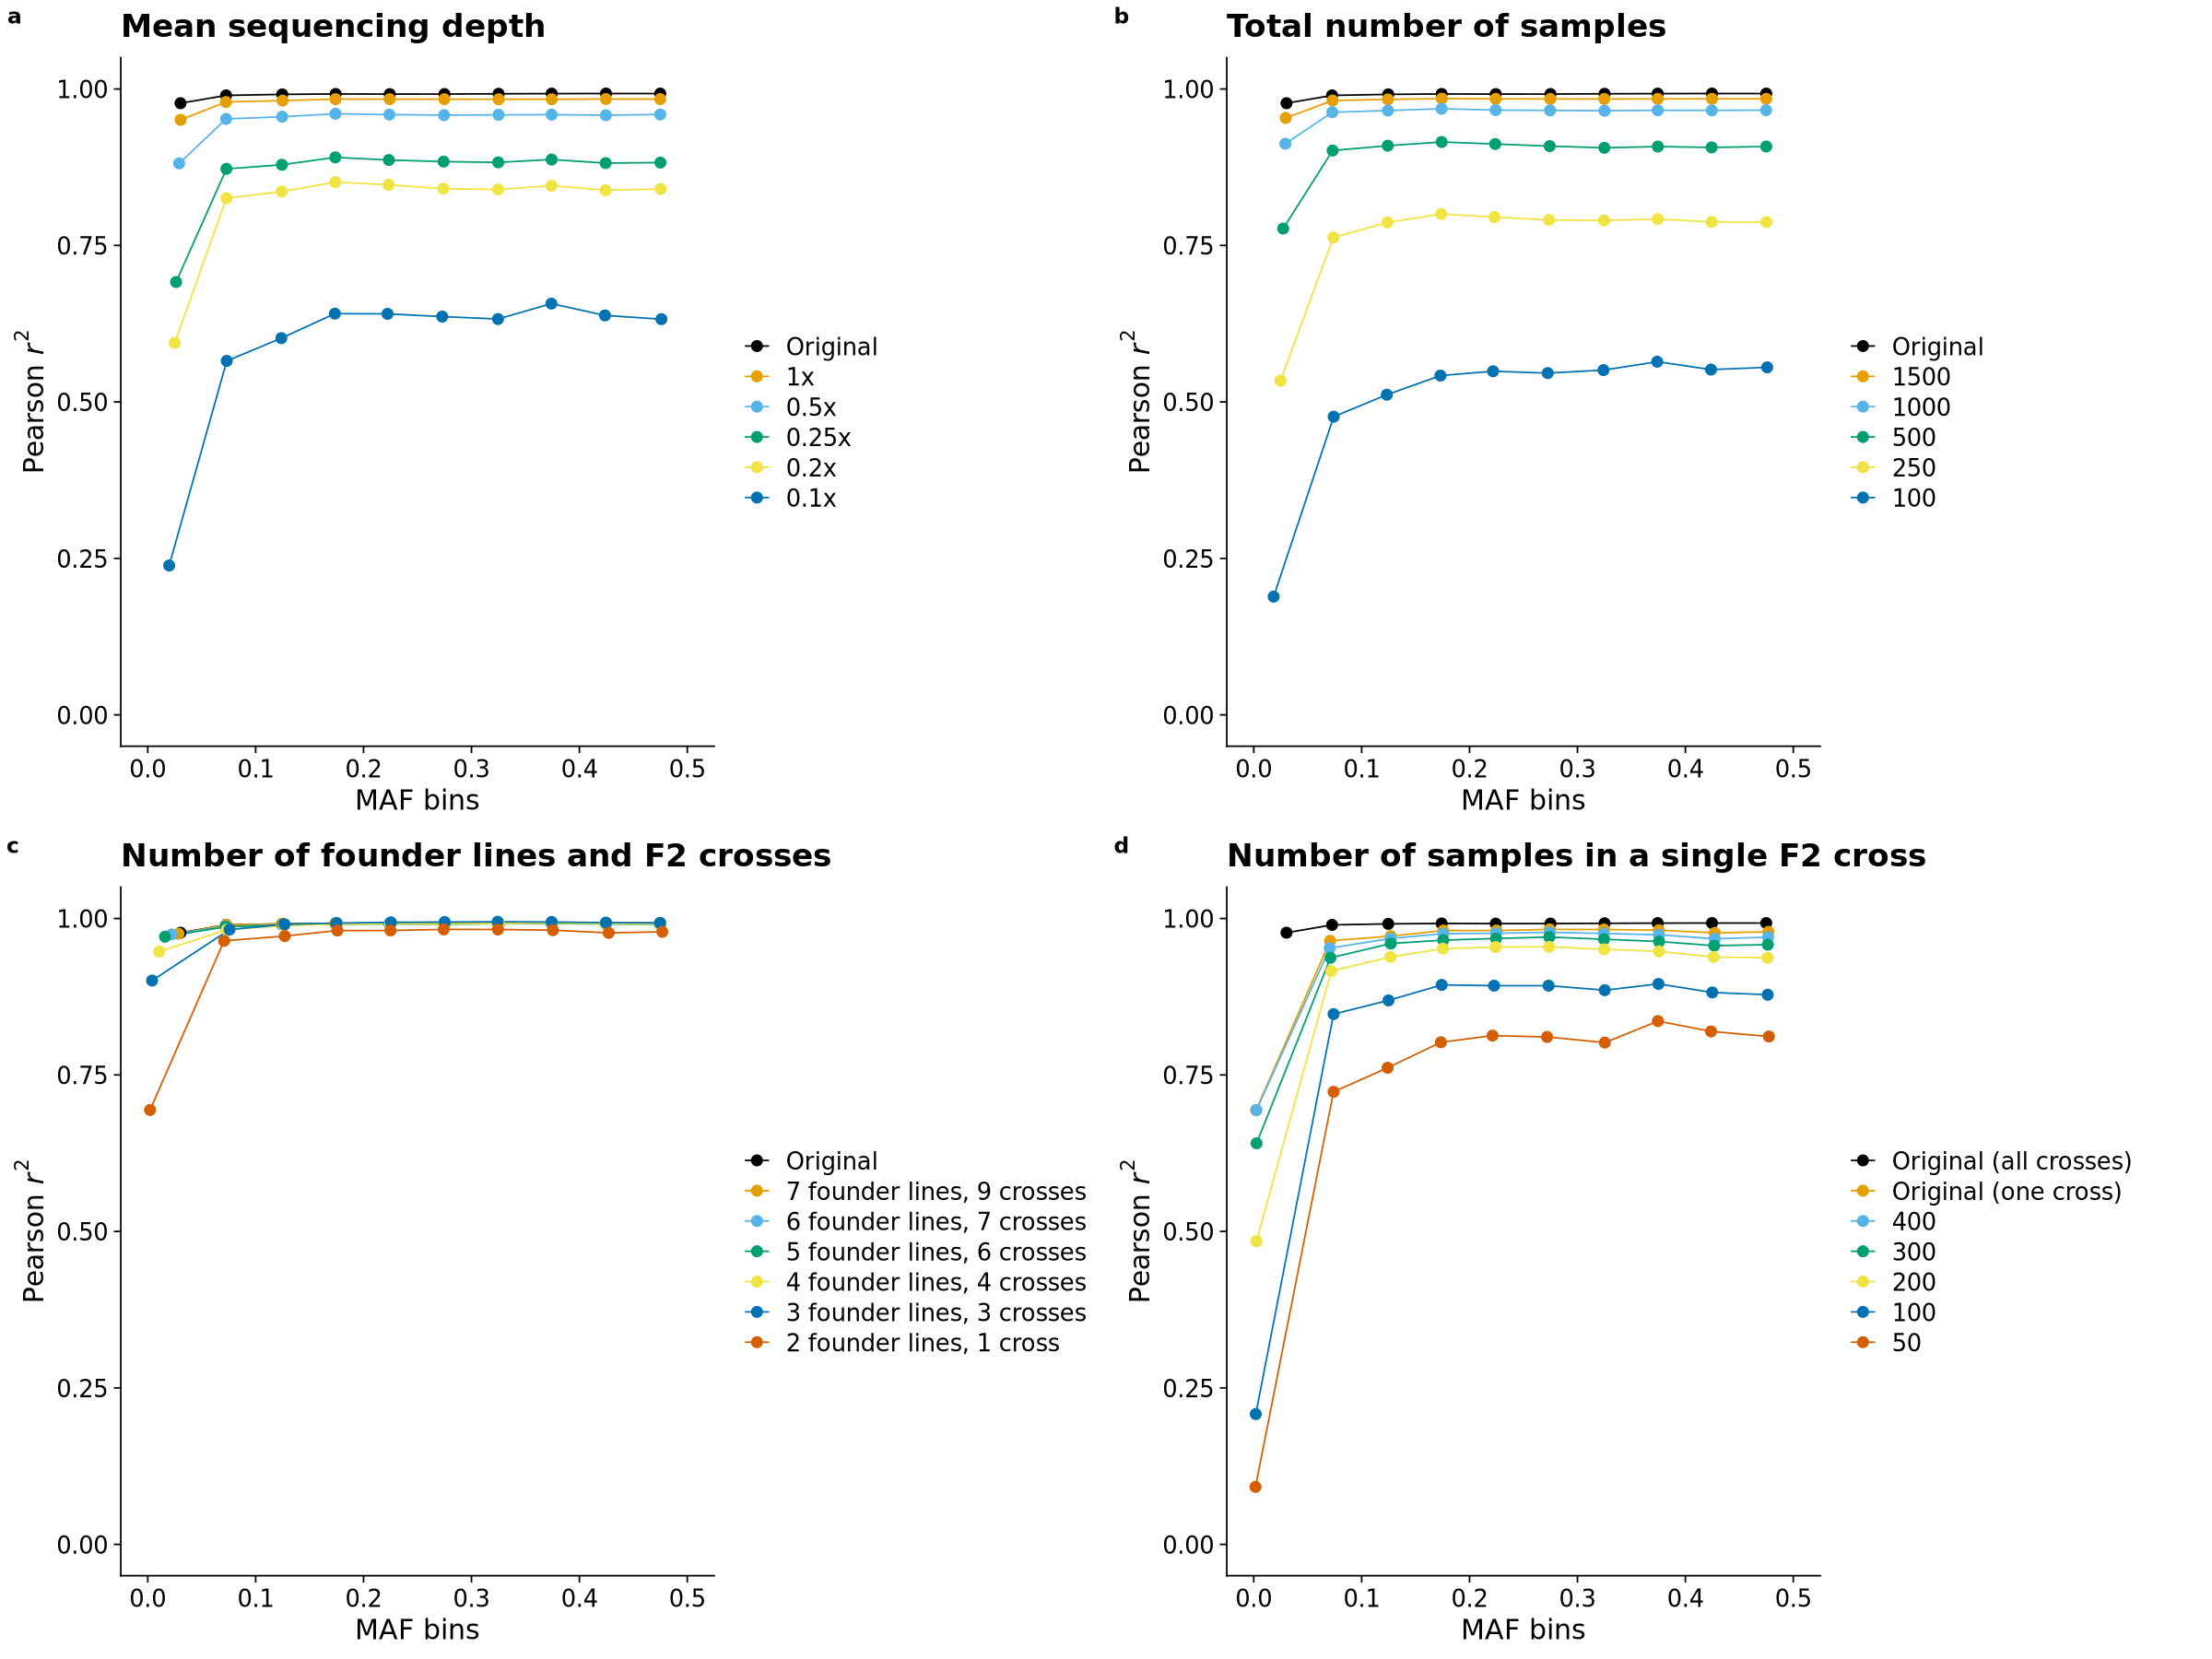

In [10]:
options(repr.plot.width = 20, repr.plot.height = 15)
p1 <- ggplot(df[is.na(downsample_type) | downsample_type == "Coverage"], aes(x = mean_AF, y = ds_r2, color = fct_reorder(group, -ds_r2))) +
    geom_line() +
    geom_point(size = 3) +
    theme_cowplot(18) +
    labs(
        x = "MAF bins",
        y = bquote(Pearson~italic(r^2)),
        color = ""
    ) +
    scale_y_continuous(limits = c(0,1)) +
    scale_color_manual(values = unname(palette.colors(palette = "Okabe-Ito"))) +
    xlim(0, 0.5) +
    ggtitle("Mean sequencing depth")

p2 <- ggplot(df[is.na(downsample_type) | downsample_type == "Samples"], aes(x = mean_AF, y = ds_r2, color = fct_reorder(group, -ds_r2))) +
    geom_line() +
    geom_point(size = 3) +
    theme_cowplot(18) +
    labs(
        x = "MAF bins",
        y = bquote(Pearson~italic(r^2)),
        color = ""
    ) +
    scale_y_continuous(limits = c(0,1)) +
    scale_color_manual(values = unname(palette.colors(palette = "Okabe-Ito"))) +
    xlim(0, 0.5) +
    ggtitle("Total number of samples")

p3 <- ggplot(
    df[is.na(downsample_type) | downsample_type == "Crosses"],
    aes(
        x = mean_AF,
        y = ds_r2,
        color = fct_relevel(
            group,
            c(
                "Original",
                "7 founder lines, 9 crosses       ",
                "6 founder lines, 7 crosses",
                "5 founder lines, 6 crosses",
                "4 founder lines, 4 crosses",
                "3 founder lines, 3 crosses",
                "2 founder lines, 1 cross"
            )
        )
    )
) +
    geom_line() +
    geom_point(size = 3) +
    theme_cowplot(18) +
    labs(
        x = "MAF bins",
        y = bquote(Pearson~italic(r^2)),
        color = ""
    ) +
    scale_y_continuous(limits = c(0,1)) +
    scale_color_manual(values = unname(palette.colors(palette = "Okabe-Ito"))) +
    xlim(0, 0.5) +
    
    ggtitle("Number of founder lines and F2 crosses")

p4 <- ggplot(
    df[is.na(downsample_type) | downsample_type == "Single cross"],
    aes(
        x = mean_AF,
        y = ds_r2,
        color = fct_recode(
            fct_reorder(group, -ds_r2),
            `Original (all crosses)` = "Original",
            `Original (one cross)` = "Single cross, all samples"
        )
    )
) +
    geom_line() +
    geom_point(size = 3) +
    theme_cowplot(18) +
    labs(
        x = "MAF bins",
        y = bquote(Pearson~italic(r^2)),
        color = ""
    ) +
    scale_y_continuous(limits = c(0,1)) +
    scale_color_manual(values = unname(palette.colors(palette = "Okabe-Ito"))) +
    xlim(0, 0.5) +
    ggtitle("Number of samples in a single F2 cross")

figure_3 <- plot_grid(
    p1, p2, p3, p4,
    axis = "tblr",
    align = "vh",
    nrow = 2,
    labels = "auto"
)

figure_3

In [97]:
ggsave(
    "/nfs/research/birney/users/saul/outputs/heart_rate_tmp/stitch_downsampling/draft_figures/figure_3_single_axis_downsampling.pdf",
    figure_3,
    width = 20,
    height = 15
)

# Figure 4 - relative cost

## Coverage by flowcell type

In [6]:
df_cov <- fread(
    cmd = "zstdcat /nfs/research/birney/users/saul/meta/heart_rate_tmp/processed/linked_meta_sequencing_sarek_phenotypes.csv.zst",
    select = c("sequencing_id", "cross_id", "medaka_type", "phenotyping_plate_id", "sequencing_sample_name", "flowcell_id", "mean_depth", "genome_size", "n_bases_sequenced", "high_cov")
)[medaka_type %in% c("F2", "F1")]

glimpse(df_cov)

Rows: 2,219
Columns: 10
$ sequencing_id          <chr> "AAAKNVNHV_F1_Sample10_9546_21s005422-1-1_Welz_…
$ cross_id               <chr> "72-2x62-2", "72-2x68-1", "72-2x22-1", "68-1x79…
$ medaka_type            <chr> "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1",…
$ phenotyping_plate_id   <chr> "", "", "", "", "", "", "", "", "", "", "BeW18"…
$ sequencing_sample_name <chr> "", "", "", "", "", "", "", "", "", "", "CPool_…
$ flowcell_id            <chr> "AAAKNVNHV", "AAAKNVNHV", "AAAKNVNHV", "AAAKNVN…
$ mean_depth             <dbl> 4.191800e+01, 3.821810e+01, 3.999342e+01, 3.637…
$ genome_size            <int> 734040372, 734040372, 734040372, 734040372, 734…
$ n_bases_sequenced      <int64> 30769507740, 28053626950, 29356781750, 267003…
$ high_cov               <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE,…


In [7]:
plate_meta <- readxl::read_excel(
    "/nfs/research/birney/users/saul/meta/heart_rate_tmp/original/F2 Heart Rate Sequencing - Metadata Linkage.xlsx",
    sheet = "Sequencing_coverage"
)
setDT(plate_meta)

plate_meta <- plate_meta[, .(sequencing_sample_name = GeneCoreSampleName, flowcell_annot = FlowCell)]
plate_meta <- distinct(plate_meta)

glimpse(plate_meta)

Rows: 7
Columns: 2
$ sequencing_sample_name <chr> "CPool_BeW19", "CPool_BeW18", "Pool_BeW20_22_23…
$ flowcell_annot         <chr> "P3", "P3", "P2 /Multiplex 3", "P3 /Multiplex 4…


In [8]:
df_cov_with_meta <- merge(plate_meta, df_cov, by = "sequencing_sample_name", all = TRUE)

glimpse(df_cov_with_meta)

Rows: 2,219
Columns: 11
$ sequencing_sample_name <chr> "", "", "", "", "", "", "", "", "", "", "BeW13_…
$ flowcell_annot         <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, "P3/Mul…
$ sequencing_id          <chr> "AAAKNVNHV_F1_Sample10_9546_21s005422-1-1_Welz_…
$ cross_id               <chr> "72-2x62-2", "72-2x68-1", "72-2x22-1", "68-1x79…
$ medaka_type            <chr> "F1", "F1", "F1", "F1", "F1", "F1", "F1", "F1",…
$ phenotyping_plate_id   <chr> "", "", "", "", "", "", "", "", "", "", "BeW13"…
$ flowcell_id            <chr> "AAAKNVNHV", "AAAKNVNHV", "AAAKNVNHV", "AAAKNVN…
$ mean_depth             <dbl> 41.9180047, 38.2180981, 39.9934157, 36.3745137,…
$ genome_size            <int> 734040372, 734040372, 734040372, 734040372, 734…
$ n_bases_sequenced      <int64> 30769507740, 28053626950, 29356781750, 267003…
$ high_cov               <lgl> TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE, TRUE,…


In [9]:
cov_summary <- df_cov_with_meta[,
    .(
        cov_tot = sum(mean_depth),
        cov_mean = mean(mean_depth),
        n_failed = sum(mean_depth < 0.5),
        fail_prob = sum(mean_depth < 0.5) / sum(!is.na(mean_depth)),
        cov_meadian = median(mean_depth),
        n_bases_sequenced_tot = sum(n_bases_sequenced),
        genome_size = max(genome_size),
        n_samples = sum(!is.na(mean_depth))
    ),
    by = c("flowcell_id", "flowcell_annot")
]
cov_summary[, n_plates := round(n_samples/90)] # 6 controls in most plates are excluded from sequencing
cov_summary[, flowcell_model := ifelse(cov_tot > 300, "P3", "P2")]
cov_summary[flowcell_id == "AAAKNVNHV", flowcell_annot := "F1 high_cov P3"]
cov_summary[flowcell_id == "AACJY7WM5", flowcell_annot := "F2 high cov P2"]
cov_summary[flowcell_id == "AAC2CVCHV", flowcell_annot := "P3/Multiplex 3"]
cov_summary[flowcell_id == "AAC2CVMHV", flowcell_annot := "P3/Multiplex 3"]

cov_summary

flowcell_id,flowcell_annot,cov_tot,cov_mean,n_failed,fail_prob,cov_meadian,n_bases_sequenced_tot,genome_size,n_samples,n_plates,flowcell_model
<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int64>,<int>,<int>,<dbl>,<chr>
AAAKNVNHV,F1 high_cov P3,372.65353,37.2653526,0,0.00000000,37.2580261,273542732637,734040372,10,0,P3
AAAT7WHHV,P3/Multiplex 3,381.96558,1.4094671,8,0.02952030,1.2582206,280378155073,734040372,271,3,P3
AAANNN2HV,P3/Multiplex 3,346.93520,1.2570116,26,0.09420290,1.1856047,254664403148,734040372,276,3,P3
AACJY7WM5,F2 high cov P2,96.76394,48.3819705,0,0.00000000,48.3819705,71028639240,734040372,2,0,P2
AAANNM2HV,P3/Multiplex 3,379.83305,1.3762067,38,0.13768116,1.2157341,278812789665,734040372,276,3,P3
AAC2CVCHV,P3/Multiplex 3,380.45750,1.3256359,44,0.15331010,1.2920634,279271163850,734040372,287,3,P3
AAC2CVMHV,P3/Multiplex 3,396.56574,1.3769644,38,0.13194444,1.2637185,291095260768,734040372,288,3,P3
AAALLVCHV,P3 /Multiplex 4,357.13639,0.9948089,48,0.13370474,0.9007416,262152531970,734040372,359,4,P3
AAAJM5YHV,P3,341.75222,3.7972469,4,0.04444444,3.4862685,250859929008,734040372,90,1,P3


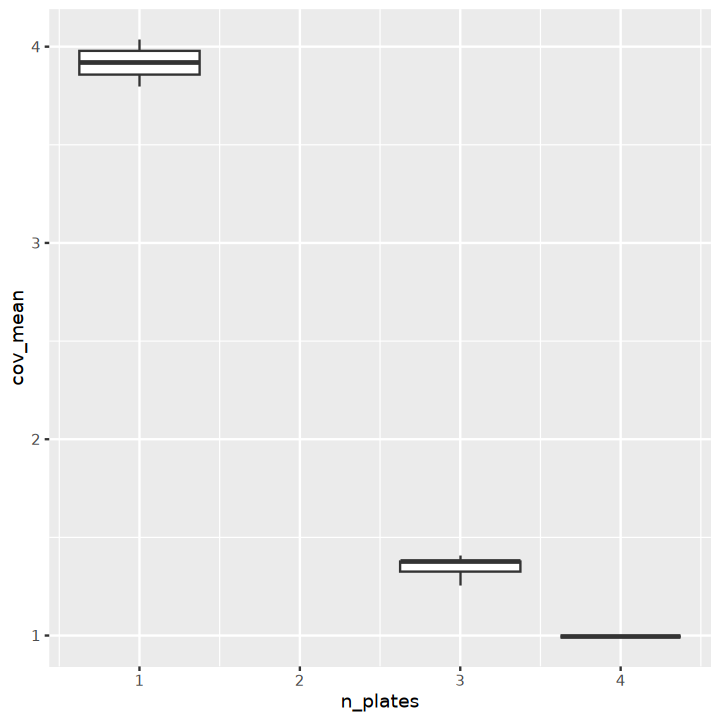

In [10]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(cov_summary[flowcell_model == "P3" & n_plates > 0], aes(x = n_plates, group = n_plates, y = cov_mean)) +
    geom_boxplot()

There are 3 samples with weird genome sizes due to very low coverage - and so not all chromosome being included

In [11]:
for (the_id in df_cov_with_meta[, unique(flowcell_id)]){
    res <- df_cov_with_meta[
        flowcell_id == the_id,
        sprintf("%s: %s", the_id, paste(unique(genome_size), collapse = ", "))
    ]
    print(res)
}

[1] "AAAKNVNHV: 734040372"
[1] "AAAT7WHHV: 734040372"
[1] "AAANNN2HV: 734040372, 124396483"
[1] "AACJY7WM5: 734040372"
[1] "AAANNM2HV: 734040372"
[1] "AAC2CVCHV: 734040372"
[1] "AAC2CVMHV: 734040372, 291352338"
[1] "AAALLVCHV: 734040372"
[1] "AAAJM5YHV: 734040372"
[1] "AAAJWVKHV: 734040372"
[1] "AAATGLFM5: 734040372, 669289465"


In [12]:
df_cov_with_meta[genome_size == 124396483]

sequencing_sample_name,flowcell_annot,sequencing_id,cross_id,medaka_type,phenotyping_plate_id,flowcell_id,mean_depth,genome_size,n_bases_sequenced,high_cov
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int64>,<lgl>
BeW15_96-1_BeW11,P3/Multiplex 3,AAANNN2HV_BeW15_96-1_BeW11_22s003651-1-1_Welz_lane1BeW11A5,15-1x62-2,F2,BeW11,AAANNN2HV,6.286351e-05,124396483,7820,FALSE


In [13]:
df_cov_with_meta[genome_size == 291352338]

sequencing_sample_name,flowcell_annot,sequencing_id,cross_id,medaka_type,phenotyping_plate_id,flowcell_id,mean_depth,genome_size,n_bases_sequenced,high_cov
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int64>,<lgl>
BeW96-7_96-8_96-9,NA,AAC2CVMHV_BeW96-7_96-8_96-9_23s001125-1-1_Welz_lane1BeWPool969H11,55-2x139-4,F2,BeW46,AAC2CVMHV,1.000507e-05,291352338,2915,FALSE


In [14]:
df_cov_with_meta[genome_size == 669289465]

sequencing_sample_name,flowcell_annot,sequencing_id,cross_id,medaka_type,phenotyping_plate_id,flowcell_id,mean_depth,genome_size,n_bases_sequenced,high_cov
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<int>,<int64>,<lgl>
Pool_BeW20_22_23,P2 /Multiplex 3,AAATGLFM5_Pool_BeW20_22_23_22s001239-1-1_Osuna_lane1BeW22A8,72-2x79-2,F2,BeW22,AAATGLFM5,2.245067e-05,669289465,15026,FALSE


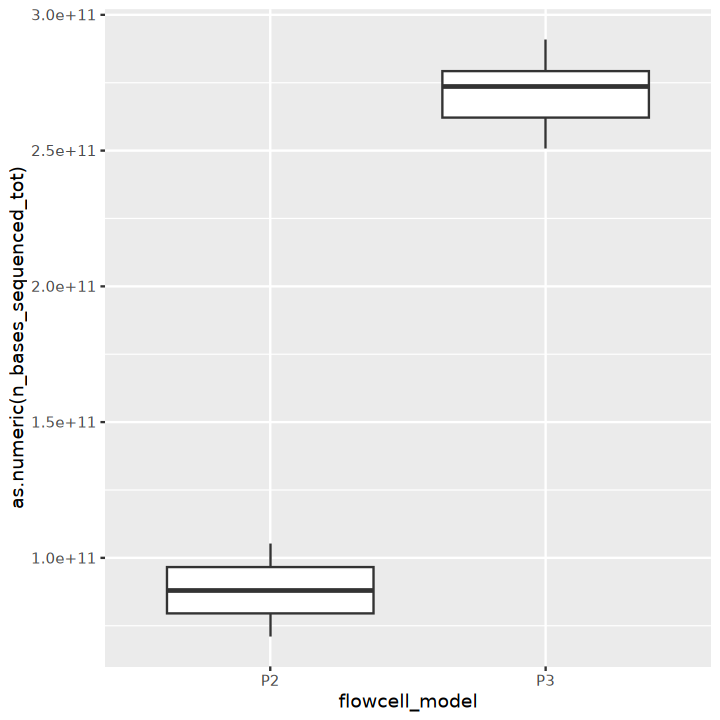

In [15]:
options(repr.plot.width = 6, repr.plot.height = 6)
ggplot(cov_summary, aes(x = flowcell_model, y = as.numeric(n_bases_sequenced_tot))) + 
    geom_boxplot()

In [16]:
cov_summary[, .(median_output_bases = median(as.numeric(n_bases_sequenced_tot))), by = flowcell_model]

flowcell_model,median_output_bases
<chr>,<dbl>
P3,273542732637
P2,88085649366


In [17]:
cov_summary[, unique(genome_size)]

[1] 734040372

## The cost model

In [42]:
get_cost <- function(
    n_samples,
    mean_depth,
    genome_size = 734040372, # medaka genome size obtained by summing ENSEMBL HdR-R reference chromosome lengths
    flowcell_output_bp = 273542732637, # observed median output after mapping and deduplication for P3 flowcells
    unitary_flowcell_cost_eur = 6155, # for the Illumina P3 at GeneCore EMBL HD
    unitary_library_prep_cost_eur = 9 # GeneCore EMBL HD
){
    bp_to_be_sequenced <- n_samples * mean_depth * genome_size
    sequencing_cost_eur <- (bp_to_be_sequenced / flowcell_output_bp) * unitary_flowcell_cost_eur
    library_prep_cost_eur <- n_samples * unitary_library_prep_cost_eur
    
    total_cost_eur <- library_prep_cost_eur + sequencing_cost_eur
    
    return(total_cost_eur)
}

Estimated cost for the real experiment

In [43]:
df_cov_with_meta[medaka_type == "F2" & high_cov == FALSE, mean(mean_depth)]

[1] 1.400722

In [44]:
df_cov_with_meta[medaka_type == "F2" & high_cov == FALSE, .N]

[1] 2207

In [45]:
f2_cost_low_cov_cost <- get_cost(n_samples = 2207, mean_depth = 1.40072214091718)
round(f2_cost_low_cov_cost)

[1] 70923

In [46]:
df_cov_with_meta[medaka_type == "F2" & high_cov == TRUE, mean(mean_depth)]

[1] 48.38197

In [47]:
df_cov_with_meta[medaka_type == "F2" & high_cov == TRUE, .N]

[1] 2

In [48]:
f2_high_cov_cost <-get_cost(n_samples = 2, mean_depth = 48.3819704946692)
round(f2_high_cov_cost)

[1] 1616

In [49]:
df_cov_with_meta[medaka_type == "F1" & high_cov == TRUE, mean(mean_depth)]

[1] 37.26535

In [50]:
df_cov_with_meta[medaka_type == "F1" & high_cov == TRUE, .N]

[1] 10

In [51]:
f1_cost <- get_cost(n_samples = 10, mean_depth = 37.2653525706894)
round(f1_cost)

[1] 6245

In [52]:
df_cov_with_meta[medaka_type %in% c("F1", "F2"), mean(mean_depth)]

[1] 1.604692

In [53]:
df_cov_with_meta[medaka_type %in% c("F1", "F2"), .N]

[1] 2219

In [54]:
get_cost(n_samples = 2219, mean_depth = 1.60469185745852) |> round()

[1] 78784

In [55]:
round(f2_cost_low_cov_cost + f2_high_cov_cost + f1_cost)

[1] 78784

## Performance

In [56]:
setwd("/nfs/research/birney/users/saul/outputs/heart_rate_tmp/stitch_downsampling")

In [57]:
read_overall <- function(filename, ...){
    df <- fread(
        filename,
        header = FALSE,
        col.names = c("sample", "gt_r2", "ds_r2")
    )

    df <- df[
        , .(
            gt_r2 = mean(gt_r2, na.rm = TRUE),
            ds_r2 = mean(ds_r2, na.rm = TRUE)
        )
    ]
    
    add_cols <- list(...)
    add_cols_names <- names(add_cols)
    
    lapply(
        add_cols_names,
        function(col_name){
            set(df, j = col_name, value = add_cols[[col_name]])
        }
    )
    
    return(df)
}

In [82]:
files <- list(
    list(
        cov = "Original",
        n_samples = "Original",
        filename = "../f1_f2/stitchimpute/K16_nGen2_downsampled_truth_stitch_downsampling_snps/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "1x",
        n_samples = "Original",
        filename = "all_samples/cov_1x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.5x",
        n_samples = "Original",
        filename = "all_samples/cov_0.5x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.25x",
        n_samples = "Original",
        filename = "all_samples/cov_0.25x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.2x",
        n_samples = "Original",
        filename = "all_samples/cov_0.2x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.1x",
        n_samples = "Original",
        filename = "all_samples/cov_0.1x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "Original",
        n_samples = "1500",
        filename = "1500_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "1x",
        n_samples = "1500",
        filename = "1500_samples/cov_1x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.5x",
        n_samples = "1500",
        filename = "1500_samples/cov_0.5x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.25x",
        n_samples = "1500",
        filename = "1500_samples/cov_0.25x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.2x",
        n_samples = "1500",
        filename = "1500_samples/cov_0.2x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.1x",
        n_samples = "1500",
        filename = "1500_samples/cov_0.1x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "Original",
        n_samples = "1000",
        filename = "1000_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "1x",
        n_samples = "1000",
        filename = "1000_samples/cov_1x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.5x",
        n_samples = "1000",
        filename = "1000_samples/cov_0.5x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.25x",
        n_samples = "1000",
        filename = "1000_samples/cov_0.25x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.2x",
        n_samples = "1000",
        filename = "1000_samples/cov_0.2x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.1x",
        n_samples = "1000",
        filename = "1000_samples/cov_0.1x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "Original",
        n_samples = "500",
        filename = "500_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "1x",
        n_samples = "500",
        filename = "500_samples/cov_1x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.5x",
        n_samples = "500",
        filename = "500_samples/cov_0.5x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.25x",
        n_samples = "500",
        filename = "500_samples/cov_0.25x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.2x",
        n_samples = "500",
        filename = "500_samples/cov_0.2x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.1x",
        n_samples = "500",
        filename = "500_samples/cov_0.1x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "Original",
        n_samples = "250",
        filename = "250_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "1x",
        n_samples = "250",
        filename = "250_samples/cov_1x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.5x",
        n_samples = "250",
        filename = "250_samples/cov_0.5x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.25x",
        n_samples = "250",
        filename = "250_samples/cov_0.25x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.2x",
        n_samples = "250",
        filename = "250_samples/cov_0.2x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.1x",
        n_samples = "250",
        filename = "250_samples/cov_0.1x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "Original",
        n_samples = "100",
        filename = "100_samples/cov_orig_downsampled_truth/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "1x",
        n_samples = "100",
        filename = "100_samples/cov_1x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.5x",
        n_samples = "100",
        filename = "100_samples/cov_0.5x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.25x",
        n_samples = "100",
        filename = "100_samples/cov_0.25x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.2x",
        n_samples = "100",
        filename = "100_samples/cov_0.2x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    ),
    list(
        cov = "0.1x",
        n_samples = "100",
        filename = "100_samples/cov_0.1x/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz"
    )
)

In [83]:
df <- lapply(files, function(...){ do.call("read_overall", ...) } ) |> rbindlist()

head(df)

gt_r2,ds_r2,cov,n_samples
<dbl>,<dbl>,<chr>,<chr>
0.9963593,0.9963140,Original,Original
0.9922906,0.9922313,1x,Original
0.9806748,0.9806542,0.5x,Original
0.9449391,0.9450707,0.25x,Original
0.9240457,0.9242859,0.2x,Original
0.8105186,0.8113531,0.1x,Original


In [84]:
df[, cov := fct_relevel(cov, rev(c("0.1x", "0.2x", "0.25x", "0.5x", "1x", "Original")))]
df[, n_samples := fct_relevel(n_samples, rev(c("250", "500", "1000", "1500", "Original")))]
df[, cov_num := ifelse(cov == "Original", 1.40072214091718, as.numeric(str_remove(cov, "x")))] # original coverage is the mean for low-coverage samples
df[, n_samples_num := ifelse(n_samples == "Original", 2219, as.numeric(as.character(n_samples)))]  # original number of samples include f2 low coverage, f2 high coverage, and f1

df[, cost := get_cost(n_samples_num, cov_num)]
df[, cost_human := get_cost(n_samples_num, cov_num, genome_size = 1e10)] # from https://www.science.org/doi/10.1126/science.abj6987#sec-2
orig_cost <- df[cov == "Original" & n_samples == "Original", cost]
orig_cost_human <- df[cov == "Original" & n_samples == "Original", cost_human]
df[, rel_cost := cost / orig_cost]
df[, rel_cost_human := cost_human / orig_cost_human]

head(df)

Warning message in ifelse(cov == "Original", 1.40072214091718, as.numeric(str_remove(cov, :
“NAs introduced by coercion”
Warning message in ifelse(n_samples == "Original", 2219, as.numeric(as.character(n_samples))):
“NAs introduced by coercion”


gt_r2,ds_r2,cov,n_samples,cov_num,n_samples_num,cost,cost_human,rel_cost,rel_cost_human
<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.9963593,0.9963140,Original,Original,1.400722,2219,71308.19,719349.33,1.0000000,1.00000000
0.9922906,0.9922313,1x,Original,1.000000,2219,56621.52,519269.40,0.7940395,0.72185986
0.9806748,0.9806542,0.5x,Original,0.500000,2219,38296.26,269620.20,0.5370527,0.37481122
0.9449391,0.9450707,0.25x,Original,0.250000,2219,29133.63,144795.60,0.4085594,0.20128691
0.9240457,0.9242859,0.2x,Original,0.200000,2219,27301.10,119830.68,0.3828607,0.16658204
0.8105186,0.8113531,0.1x,Original,0.100000,2219,23636.05,69900.84,0.3314633,0.09717232


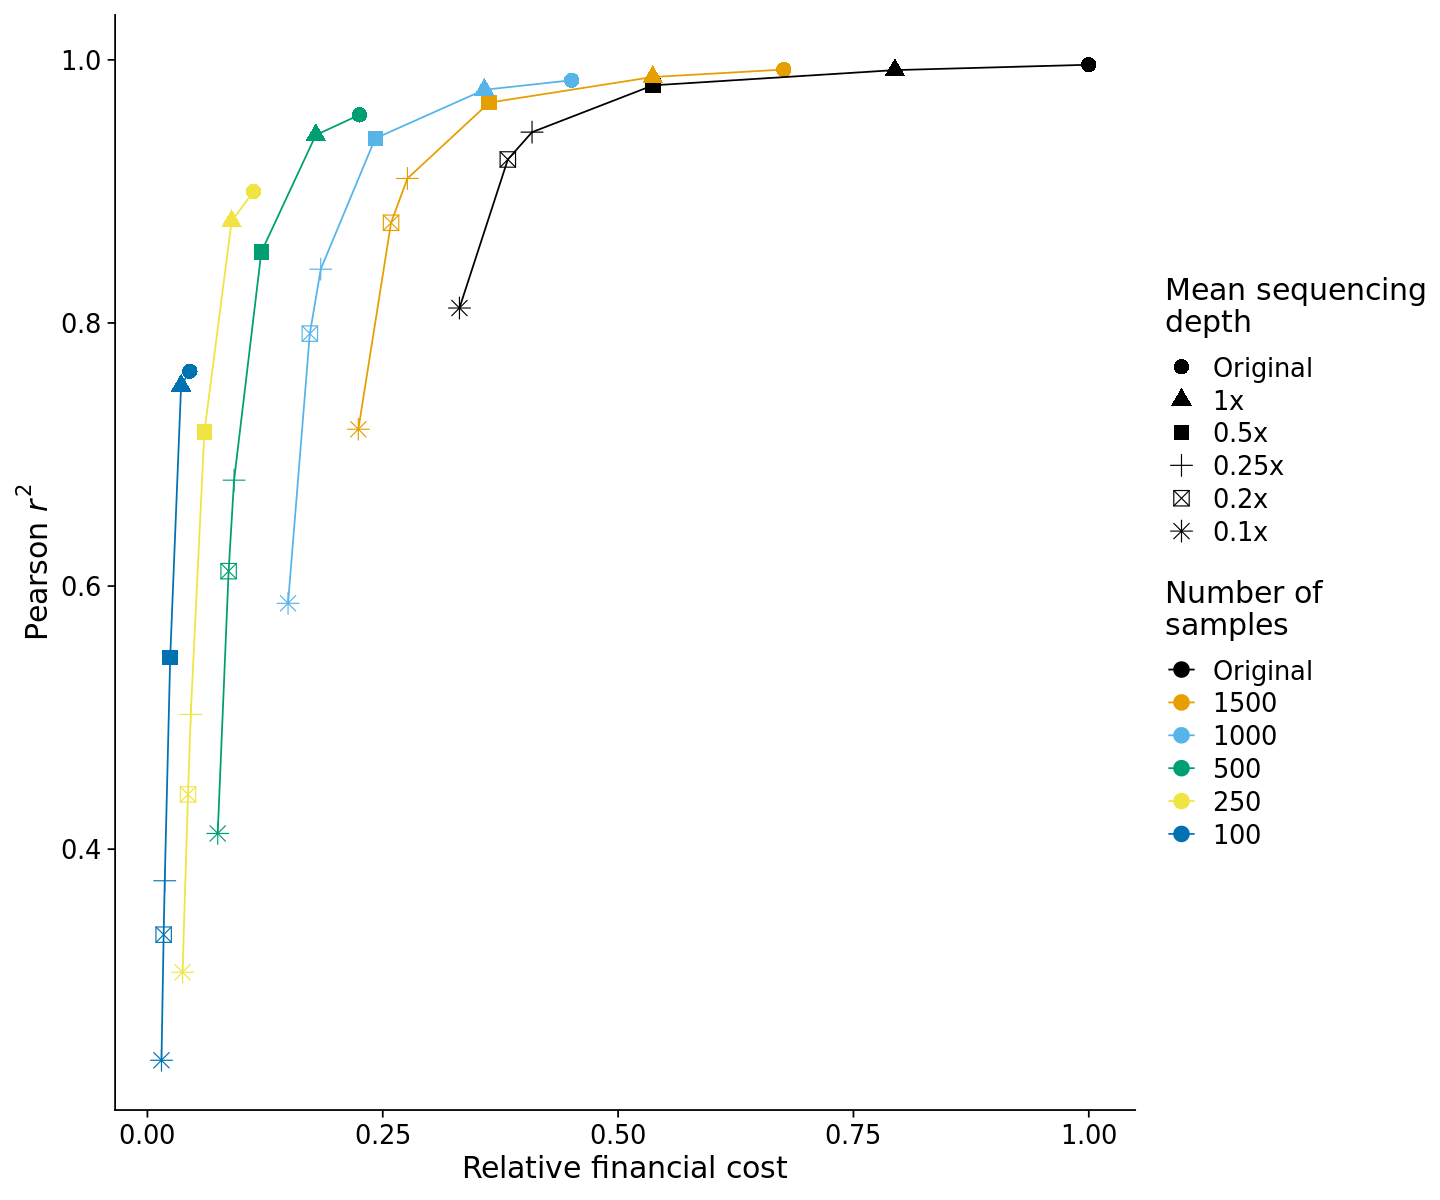

In [85]:
options(repr.plot.width = 12, repr.plot.height = 10)
figure_4 <- ggplot(df, aes(x = rel_cost, y = ds_r2, group = n_samples, color = n_samples, shape = cov)) +
    geom_point(size = 4) +
    geom_line() +
    theme_cowplot(18) +
    scale_color_manual(values = unname(palette.colors(palette = "Okabe-Ito"))) +
    labs(
        x = "Relative financial cost",
        y = bquote(Pearson~italic(r^2)),
        shape = "Mean sequencing\ndepth",
        color = "Number of\nsamples"
    )

figure_4

In [86]:
ggsave(
    "/nfs/research/birney/users/saul/outputs/heart_rate_tmp/stitch_downsampling/draft_figures/figure_4_economic_model.pdf",
    figure_4,
    width = 12,
    height = 10
)

# Figure S1 - Coverage

In [54]:
df <- fread(
    cmd = "zstdcat /nfs/research/birney/users/saul/meta/heart_rate_tmp/processed/linked_meta_sequencing_sarek.csv.zst"
)

df[sequencing_well != "", sequencing_well_row := str_remove(sequencing_well, "\\d\\d$")]
df[sequencing_well != "", sequencing_well_col := str_remove(sequencing_well, sequencing_well_row)]

glimpse(df)

Rows: 2,489
Columns: 33
$ sequencing_id          <chr> "AAAJM5YHV_CPool_BeW18_21s005266-1-1_Welz_lane1…
$ sample_id              <chr> "", "", "", "", "", "", "", "", "", "", "", "",…
$ sample_name            <chr> "", "", "", "", "", "", "", "", "", "", "", "",…
$ cross_id               <chr> "72-2x68-1", "72-2x68-1", "72-2x68-1", "72-2x68…
$ medaka_strain          <chr> "F2_72-2x68-1", "F2_72-2x68-1", "F2_72-2x68-1",…
$ medaka_type            <chr> "F2", "F2", "F2", "F2", "F2", "F2", "F2", "F2",…
$ is_pooled              <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE…
$ phenotyping_plate_id   <chr> "BeW18", "BeW18", "BeW18", "BeW18", "BeW18", "B…
$ phenotyping_well       <chr> "A01", "A10", "A11", "A12", "A02", "A03", "A04"…
$ experiment_21C         <chr> "210719155352_OlE_HR_IPF2_2x_BQ_21C", "21071915…
$ experiment_28C         <chr> "210719170353_OlE_HR_IPF2_2x_BQ_28C", "21071917…
$ experiment_35C         <chr> "210719181906_OlE_HR_IPF2_2x_BQ_35C", "21071918…
$ sequencing_wel

Warning message:
“Removed 1 row containing missing values
or values outside the scale range
(`geom_bar()`).”


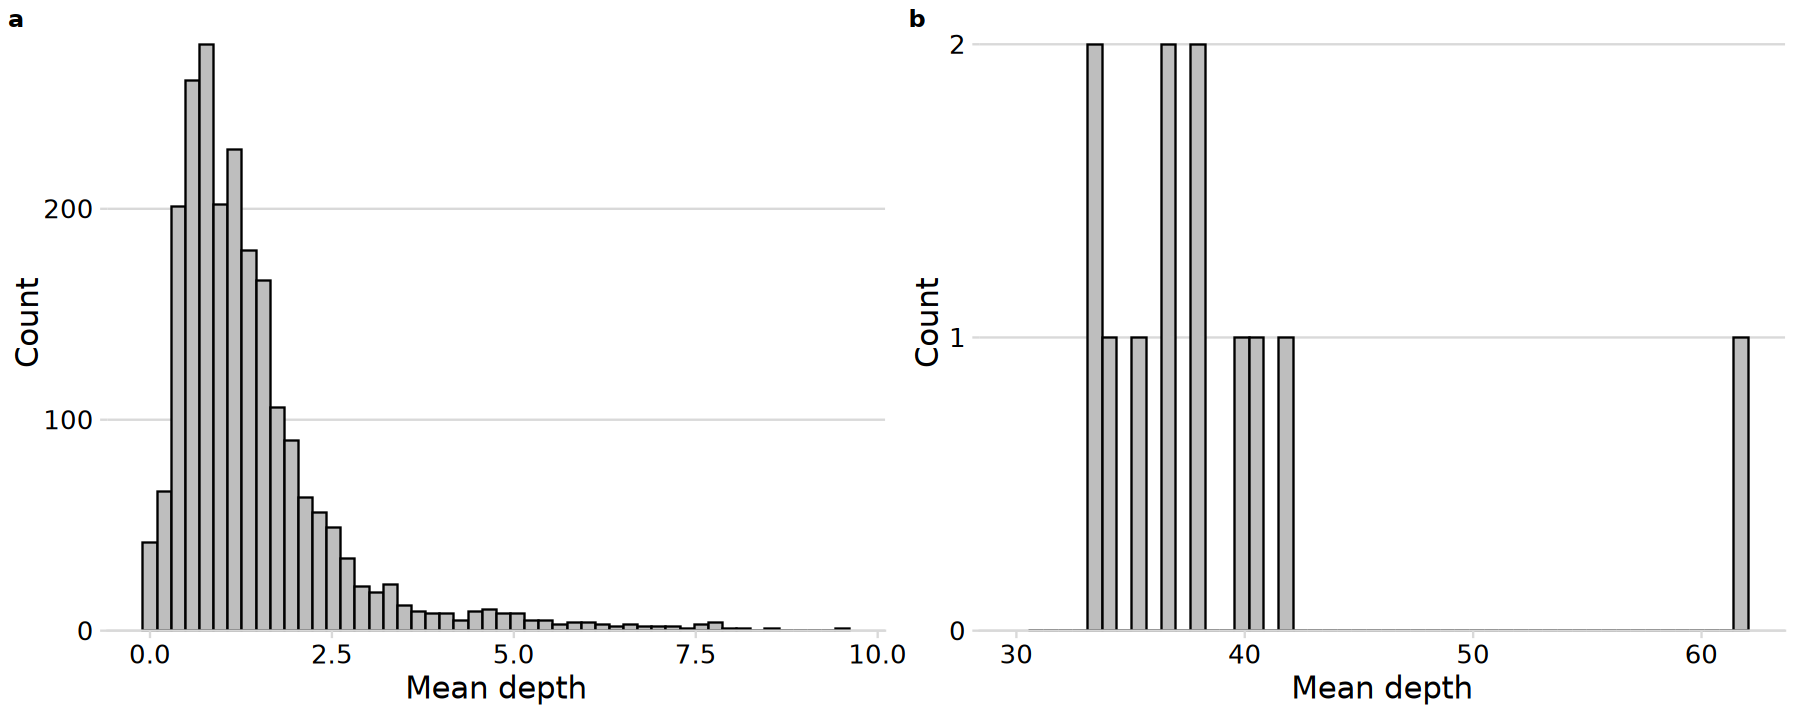

In [55]:
options(repr.plot.width = 15, repr.plot.height = 6)
p1 <- ggplot(df[medaka_type %in% c("F1", "F2") & high_cov == FALSE], aes(x = mean_depth)) +
    geom_histogram(bins = 50,  color = "black", fill = "grey") +
    theme_minimal_hgrid(18) +
    labs(y = "Count", x = "Mean depth") +
    scale_y_continuous(
        expand = expansion(mult = c(0, 0.05))
    )

p2 <- ggplot(df[medaka_type %in% c("F1", "F2") & high_cov == TRUE], aes(x = mean_depth)) +
    geom_histogram(bins = 50, color = "black", fill = "grey") +
    theme_minimal_hgrid(18) +
    labs(y = "Count", x = "Mean depth") +
    scale_y_continuous(
        expand = expansion(mult = c(0, 0.05)),
        breaks = 0:2
    ) +
    scale_x_continuous(
        breaks = seq(0, 65, 10),
        limits = c(30, NA)
    )

figure_s1 <- plot_grid(p1, p2, nrow = 1, labels = "auto")

figure_s1

In [56]:
ggsave(
    "/nfs/research/birney/users/saul/notebooks/figure_s1a_coverage.pdf",
    p1,
    width = 7,
    height = 6
)

In [57]:
ggsave(
    "/nfs/research/birney/users/saul/outputs/heart_rate_tmp/stitch_downsampling/draft_figures/figure_s1_coverage.pdf",
    figure_s1,
    width = 15,
    height = 6
)

# Figure S3 - F1 vs F2

In [58]:
the_ids <- c(
    "72-2x55-2 F2 (1)" = "AACJY7WM5_BeW43_Well_F6_23s001218-1-1_Welz_lane123s001218_AACJY7WM5_BeW43_Well_F6_23s001218-1-1_Welz_lane123s001218",
    "72-2x55-2 F2 (2)" = "AACJY7WM5_BeW43_Well_F4_23s001217-1-1_Welz_lane123s001217_AACJY7WM5_BeW43_Well_F4_23s001217-1-1_Welz_lane123s001217",
    "72-2x55-2 F1" = "AAAKNVNHV_F1_Sample8_9545_21s005421-1-1_Welz_lane121s005421_AAAKNVNHV_F1_Sample8_9545_21s005421-1-1_Welz_lane121s005421"
)

reverse_map <- names(the_ids)
names(reverse_map) <- the_ids

In [60]:
all_files <- fread("/nfs/research/birney/users/saul/notebooks/heart_rate_tmp/stitch_downsample/f1_f2_performance_comparison_paths.txt", header = FALSE)[[1]]

In [61]:
read_file <- function(f) {
    fread(f)[V1 %in% the_ids, .(sample = reverse_map[V1], ds_r2 = V3, group = f)]
}

In [62]:
df <- lapply(all_files, read_file) |> rbindlist()

head(df)

sample,ds_r2,group
<chr>,<dbl>,<chr>
72-2x55-2 F1,0.998132,/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/iteration_5_filtered_snps_downsampled_truth_param_optimisation/K_16_nGen_10/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz
72-2x55-2 F2 (2),0.998959,/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/iteration_5_filtered_snps_downsampled_truth_param_optimisation/K_16_nGen_10/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz
72-2x55-2 F2 (1),0.997521,/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/iteration_5_filtered_snps_downsampled_truth_param_optimisation/K_16_nGen_10/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz
72-2x55-2 F1,0.997436,/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/iteration_5_filtered_snps_downsampled_truth_param_optimisation/K_16_nGen_1/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz
72-2x55-2 F2 (2),0.998802,/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/iteration_5_filtered_snps_downsampled_truth_param_optimisation/K_16_nGen_1/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz
72-2x55-2 F2 (1),0.998523,/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/iteration_5_filtered_snps_downsampled_truth_param_optimisation/K_16_nGen_1/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz


In [63]:
df_long <- dcast(df, group ~ sample, value.var = "ds_r2")
head(df_long)

group,72-2x55-2 F1,72-2x55-2 F2 (1),72-2x55-2 F2 (2)
<chr>,<dbl>,<dbl>,<dbl>
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_1/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.868626,0.905758,0.901790
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_2/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.973970,0.984002,0.984741
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_3/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.985585,0.991872,0.993029
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_4/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.992198,0.995461,0.996584
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_5/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.997794,0.998249,0.998484
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_stitch_downsampling_snps/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.998406,0.998812,0.999066


In [64]:
df_plot <- melt(df_long, id.vars = c("group", "72-2x55-2 F1"), variable.name = "f2_sample", value.name = "f2_ds_r2")
head(df_plot)

group,72-2x55-2 F1,f2_sample,f2_ds_r2
<chr>,<dbl>,<fct>,<dbl>
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_1/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.868626,72-2x55-2 F2 (1),0.905758
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_2/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.973970,72-2x55-2 F2 (1),0.984002
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_3/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.985585,72-2x55-2 F2 (1),0.991872
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_4/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.992198,72-2x55-2 F2 (1),0.995461
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_5/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.997794,72-2x55-2 F2 (1),0.998249
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_stitch_downsampling_snps/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.998406,72-2x55-2 F2 (1),0.998812


In [65]:
df_plot[, f1_rank := rank(`72-2x55-2 F1`), by = f2_sample]
df_plot[, f2_rank := rank(f2_ds_r2), by = f2_sample]
head(df_plot)

group,72-2x55-2 F1,f2_sample,f2_ds_r2,f1_rank,f2_rank
<chr>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_1/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.868626,72-2x55-2 F2 (1),0.905758,16,17
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_2/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.973970,72-2x55-2 F2 (1),0.984002,31,32
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_3/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.985585,72-2x55-2 F2 (1),0.991872,36,38
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_4/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.992198,72-2x55-2 F2 (1),0.995461,40,41
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_5/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.997794,72-2x55-2 F2 (1),0.998249,58,58
/nfs/research/birney/users/saul//outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_stitch_downsampling_snps/imputation_metrics/joint_stitch_output.rsquare.spl.txt.gz,0.998406,72-2x55-2 F2 (1),0.998812,64,64


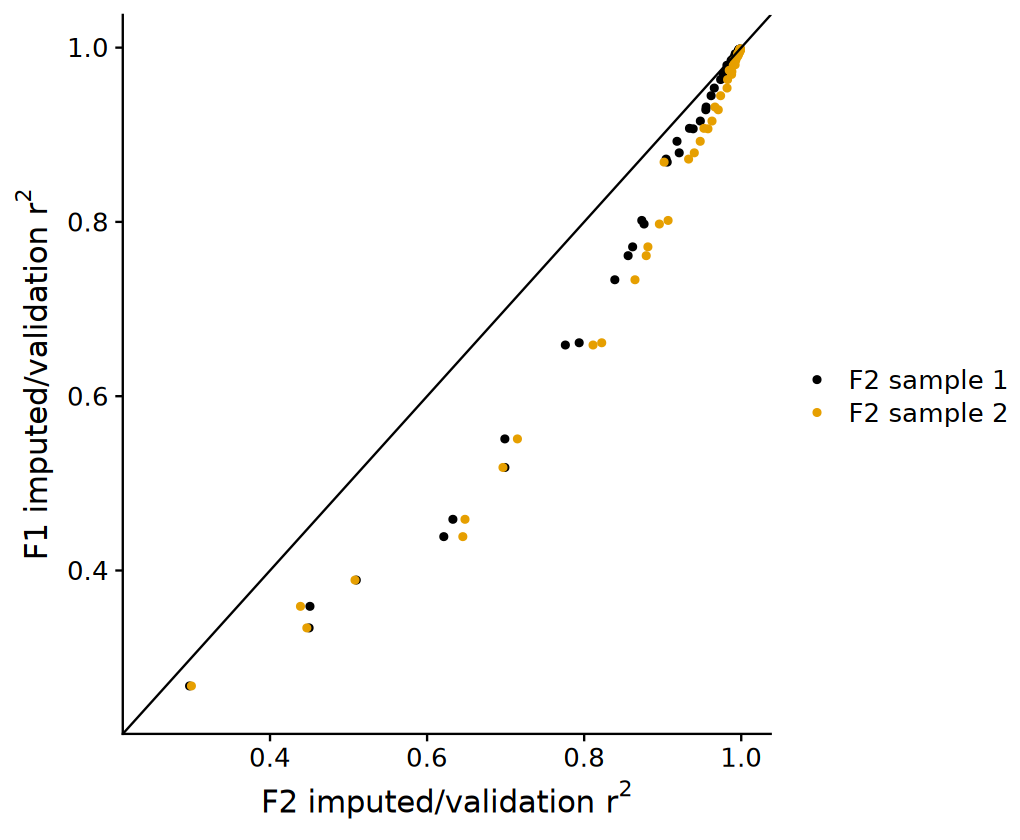

In [69]:
options(repr.plot.width = 8.5, repr.plot.height = 7)
figure_s3 <- ggplot(df_plot, aes(x = f2_ds_r2, y = `72-2x55-2 F1`, color = f2_sample)) +
    geom_point() +
    geom_abline(intercept = 0, slope = 1) +
    xlim(0.25, 1) +
    ylim(0.25, 1) +
    labs(
        x = bquote("F2 imputed/validation"~r^2),
        y = bquote("F1 imputed/validation"~r^2),
        color = ""
    ) +
    theme_cowplot(18) +
    scale_color_manual(values = c("black", "#E69F00"), label = c("F2 sample 1", "F2 sample 2"))

figure_s3

In [70]:
ggsave(
    "/nfs/research/birney/users/saul/outputs/heart_rate_tmp/stitch_downsampling/draft_figures/figure_s3_f1_f2_performance.pdf",
    figure_s3,
    width = 8.5,
    height = 7
)

In [67]:
df_plot[, .(spearman_r = cor(`72-2x55-2 F1`, f2_ds_r2, method = "spearman")), by = f2_sample]

f2_sample,spearman_r
<fct>,<dbl>
72-2x55-2 F2 (1),0.9891026
72-2x55-2 F2 (2),0.9933608


# Figure S4 - Iterative filtering vs info score

In [71]:
setwd("/nfs/research/birney/users/saul/outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/")

In [72]:
input_r2 <- list(
    list(file = "iteration_1/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz", iteration = 1),
    list(file = "iteration_2/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz", iteration = 2),
    list(file = "iteration_3/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz", iteration = 3),
    list(file = "iteration_4/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz", iteration = 4),
    list(file = "iteration_5/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz", iteration = 5)
)

In [73]:
read_r2 <- function(file, iteration){
    df <- fread(file)[
        order(ds_r2),
        .(chr, pos, ref = allele1, alt = allele2, iteration = ..iteration, ds_r2)
    ]
    return(df)
}

In [74]:
df_r2 <- lapply(input_r2, function(...){ do.call(read_r2, ...) }) %>% rbindlist()

In [75]:
head(df_r2)

chr,pos,ref,alt,iteration,ds_r2
<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
1,8540,A,C,1,0
1,8664,T,A,1,0
1,12989,T,G,1,0
1,13217,A,C,1,0
1,13234,A,C,1,0
1,13314,G,T,1,0


In [76]:
inputs_info_score <- list(
    list(file = "iteration_1/imputation_metrics/joint_stitch_output.info_score.csv.gz", iteration = 1),
    list(file = "iteration_2/imputation_metrics/joint_stitch_output.info_score.csv.gz", iteration = 2),
    list(file = "iteration_3/imputation_metrics/joint_stitch_output.info_score.csv.gz", iteration = 3),
    list(file = "iteration_4/imputation_metrics/joint_stitch_output.info_score.csv.gz", iteration = 4),
    list(file = "iteration_5/imputation_metrics/joint_stitch_output.info_score.csv.gz", iteration = 5)
)

In [77]:
read_info_score <- function(file, iteration){
    df <- fread(file)[
        order(info_score),
        .(chr, pos, ref, alt, iteration = ..iteration, info_score)
    ]
    return(df)
}

In [78]:
df_info_score <- lapply(inputs_info_score, function(...){ do.call(read_info_score, ...) }) %>% rbindlist()

In [79]:
head(df_info_score)

chr,pos,ref,alt,iteration,info_score
<int>,<int>,<chr>,<chr>,<dbl>,<dbl>
8,25842981,T,G,1,0
23,2090982,G,A,1,0
23,3488786,A,T,1,0
23,19956928,G,C,1,0
23,20291501,G,C,1,0
23,20302511,A,T,1,0


In [80]:
df <- merge(df_r2, df_info_score, all = TRUE)
df[, .N]
df_r2[, .N]
df_info_score[, .N]

[1] 20589433

[1] 20501862

[1] 20589433

In [84]:
plot_df <- df[iteration %in% c(1, 5)]
head(plot_df)

chr,pos,ref,alt,iteration,ds_r2,info_score
<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,8540,A,C,1,0,1.00000
1,8603,G,A,1,NA,1.00000
1,8664,T,A,1,0,0.43753
1,10388,G,C,1,NA,0.47357
1,10391,G,C,1,NA,0.61106
1,12989,T,G,1,0,1.00000


In [85]:
plot_df2 <- rbind(
    plot_df[iteration == 1 & info_score > 0.4, .(chr, pos, ref, alt, info_score, ds_r2, group = "info_0.4")],
    plot_df[iteration == 1 & info_score > 0.9, .(chr, pos, ref, alt, info_score, ds_r2, group = "info_0.9")],
    plot_df[iteration == 1, .(chr, pos, ref, alt, info_score, ds_r2, group = "original")],
    plot_df[iteration == 5, .(chr, pos, ref, alt, info_score, ds_r2, group = "iterative_filter")]
)

In [86]:
plot_df2[, .(n_millions = round(.N/1e6, 2)), by = group]

group,n_millions
<chr>,<dbl>
info_0.4,5.45
info_0.9,3.23
original,6.51
iterative_filter,3.20


Warning message:
“Removed 562486 rows containing non-finite
outside the scale range (`stat_bin()`).”


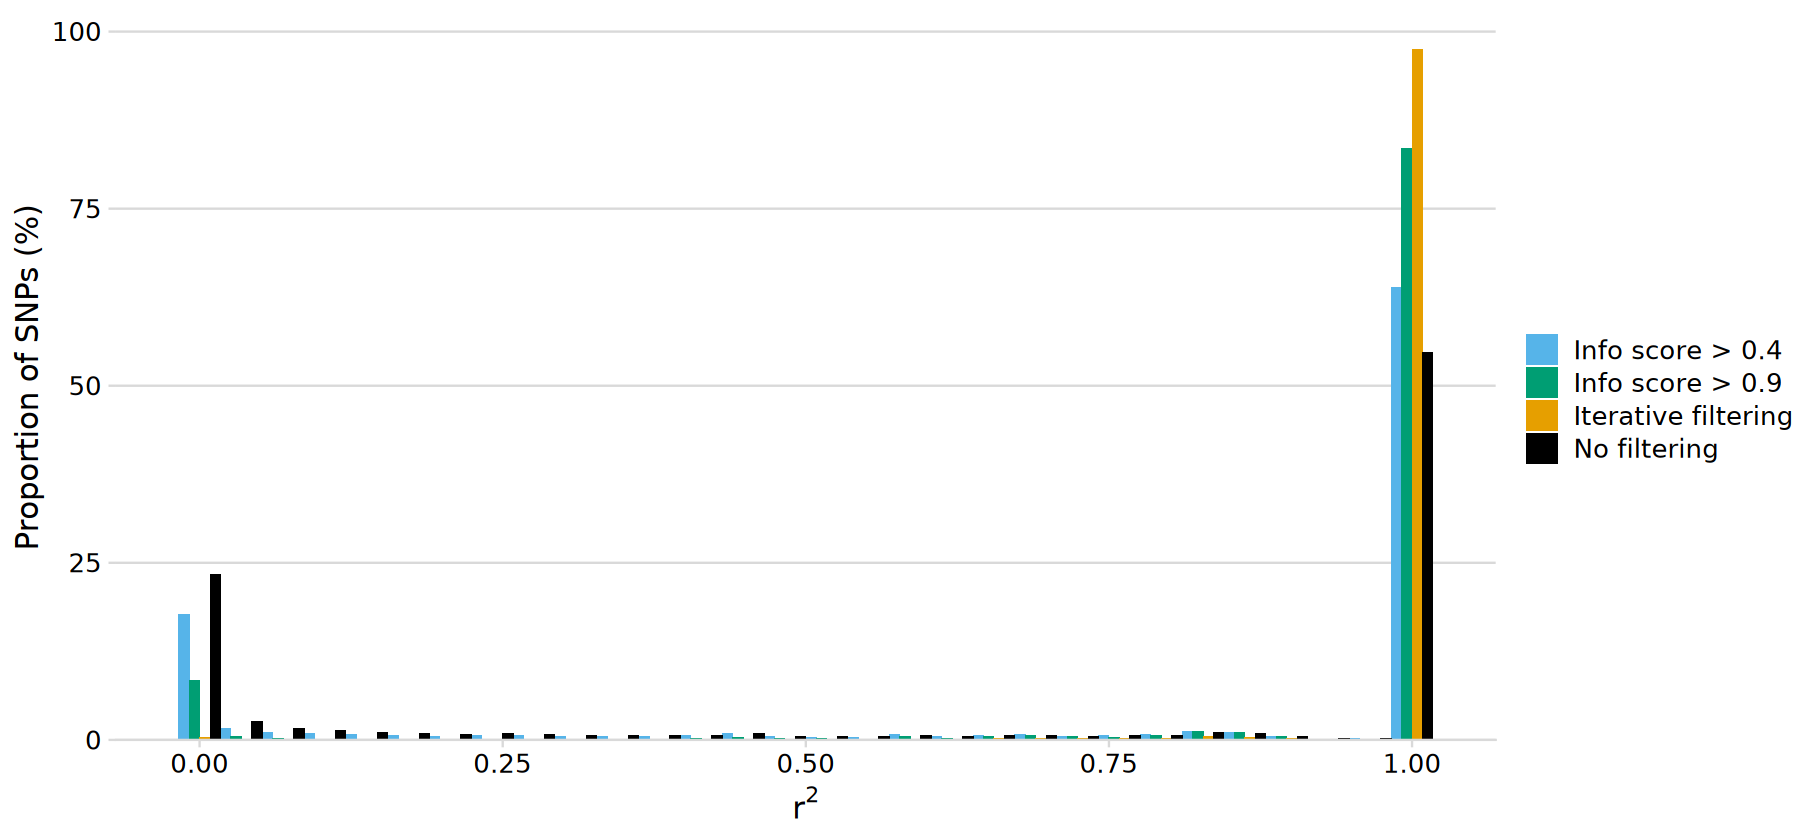

In [87]:
options(repr.plot.width = 15, repr.plot.height = 7)
figure_s4 <- ggplot(plot_df2, aes(x = ds_r2, y = after_stat(density * width) * 100, fill = group)) +
    geom_histogram(position = "dodge", bins = 30) +
    theme_minimal_hgrid(18) +
    scale_y_continuous(expand = expansion(mult = c(0, 0.05))) +
    scale_fill_manual(
        values = c("original" = "black", "iterative_filter" = "#E69F00", "info_0.4" = "#56B4E9", "info_0.9" = "#009E73"),
        labels = c("original" = "No filtering", "iterative_filter" = "Iterative filtering", "info_0.4" = "Info score > 0.4", "info_0.9" = "Info score > 0.9")
    ) +
    labs(x = bquote(r^2), y = "Proportion of SNPs (%)", fill = "")

figure_s4

In [109]:
ggsave(
    "/nfs/research/birney/users/saul/outputs/heart_rate_tmp/stitch_downsampling/draft_figures/figure_s4_filtering_strategies.pdf",
    figure_s4,
    width = 15,
    height = 7
)

Warning message:
“Removed 562486 rows containing non-finite
outside the scale range (`stat_bin()`).”


# Supplementary note - r2 vs info score

In [90]:
read_info_score <- function(filename, ...){
    df <- fread(filename)

    add_cols <- list(...)
    add_cols_names <- names(add_cols)
    
    lapply(
        add_cols_names,
        function(col_name){
            set(df, j = col_name, value = add_cols[[col_name]])
        }
    )
    
    return(df)
}

In [91]:
read_r2 <- function(filename, ...){
    df <- fread(filename)

    df <- df[, 
        .(
            chr,
            pos,
            ref = allele1,
            alt = allele2,
            ds_r2
        )
    ]
    
    add_cols <- list(...)
    add_cols_names <- names(add_cols)
    
    lapply(
        add_cols_names,
        function(col_name){
            set(df, j = col_name, value = add_cols[[col_name]])
        }
    )

    return(df)
}

In [92]:
files_info_score <- list(
    list(
        group = "After SNP filtering",
        filename = paste0(
            "/nfs/research/birney/users/saul/outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_stitch_downsampling_snps/imputation_metrics/joint_stitch_output.info_score.csv.gz"
        )
    ),
    list(
        group = "Before SNP filtering",
        filename = paste0(
            "/nfs/research/birney/users/saul/outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_1/imputation_metrics/joint_stitch_output.info_score.csv.gz"
        )
    )
)

In [93]:
files_r2 <- list(
    list(
        group = "After SNP filtering",
        filename = paste0(
            "/nfs/research/birney/users/saul/outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_stitch_downsampling_snps/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz"
        )
    ),
    list(
        group = "Before SNP filtering",
        filename = paste0(
            "/nfs/research/birney/users/saul/outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_snp_set_refinement/iteration_1/imputation_metrics/joint_stitch_output.r2_sites.tsv.gz"
        )
    )
)

In [94]:
df_info_score <- lapply(files_info_score, function(...){ do.call("read_info_score", ...) } ) |>
    rbindlist()

glimpse(df_info_score)

Rows: 9,632,415
Columns: 6
$ chr        <int> 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,…
$ pos        <int> 458, 11169, 11952, 13004, 13390, 15644, 15987, 16159, 17803…
$ ref        <chr> "T", "T", "A", "T", "G", "T", "G", "A", "G", "C", "T", "C",…
$ alt        <chr> "C", "G", "G", "C", "C", "C", "A", "T", "T", "T", "C", "T",…
$ info_score <dbl> 0.88421, 0.99634, 0.99688, 0.99573, 0.99667, 0.99753, 0.949…
$ group      <chr> "After SNP filtering", "After SNP filtering", "After SNP fi…


In [95]:
df_r2 <- lapply(files_r2, function(...){ do.call("read_r2", ...) } ) |>
    rbindlist()

glimpse(df_r2)

Rows: 9,544,844
Columns: 6
$ chr   <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ pos   <int> 15801, 20392, 20410, 20440, 20575, 20728, 21190, 21205, 21341, 2…
$ ref   <chr> "C", "C", "A", "C", "G", "G", "T", "A", "G", "G", "G", "C", "T",…
$ alt   <chr> "T", "A", "G", "T", "C", "T", "C", "G", "A", "T", "A", "A", "A",…
$ ds_r2 <dbl> 0.999998, 0.999997, 0.998349, 0.000000, 0.999947, 0.999262, 0.99…
$ group <chr> "After SNP filtering", "After SNP filtering", "After SNP filteri…


In [96]:
df <- merge(df_info_score, df_r2, all = TRUE)
glimpse(df)

Rows: 9,632,415
Columns: 7
$ chr        <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ pos        <int> 8540, 8603, 8664, 10388, 10391, 12989, 13217, 13234, 13314,…
$ ref        <chr> "A", "G", "T", "G", "G", "T", "A", "A", "G", "C", "G", "A",…
$ alt        <chr> "C", "A", "A", "C", "C", "G", "C", "C", "T", "A", "A", "T",…
$ group      <chr> "Before SNP filtering", "Before SNP filtering", "Before SNP…
$ info_score <dbl> 1.00000, 1.00000, 0.43753, 0.47357, 0.61106, 1.00000, 1.000…
$ ds_r2      <dbl> 0.000000, NA, 0.000000, NA, NA, 0.000000, 0.000000, 0.00000…


Warning message:
“Removed 4924 rows containing missing
values or values outside the scale range
(`geom_point()`).”


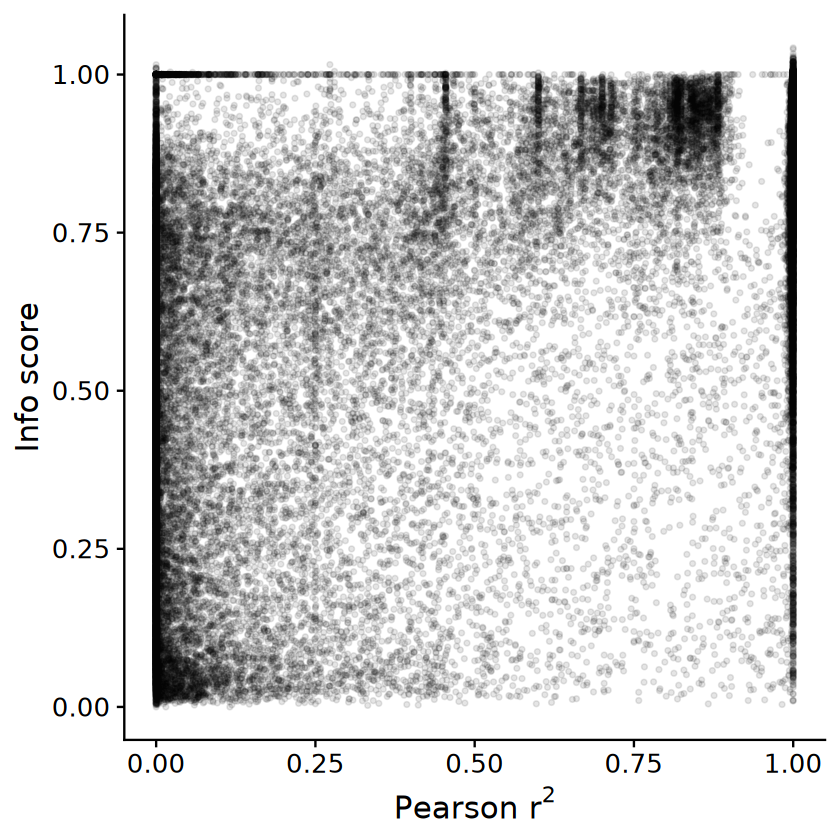

In [97]:
options(repr.plot.width = 7, repr.plot.height = 7)
ggplot(df[group == "Before SNP filtering"][sample(1:.N, 100000)], aes(x = ds_r2, y = info_score)) +
    geom_point(size = 1, alpha = 0.1) +
    theme_cowplot(18) +
    labs(x = bquote(Pearson~r^2), y = "Info score")

In [98]:
df[
    !is.na(ds_r2),
    .(
        n = round(.N/1e6, 1),
        pearson = round(cor(ds_r2, info_score, method = "pearson"), 2),
        spearman = round(cor(ds_r2, info_score, method = "spearman"), 2)
    ), by = group
]

group,n,pearson,spearman
<chr>,<dbl>,<dbl>,<dbl>
Before SNP filtering,6.2,0.64,0.58
After SNP filtering,3.1,0.17,0.51


# Figure S5 - Effect of filtering on MAF

In [99]:
setwd("/nfs/research/birney/users/saul/outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_stitch_downsampling_snps/manual_maf_by_cross/")

In [100]:
snp_freq1 <- fread(cmd = "zstdcat iteration_1.afreq.zst")[, iteration := 1]

In [101]:
snp_freq5 <- fread(cmd = "zstdcat iteration_5.afreq.zst")[, iteration := 5]

In [102]:
df_raw <- rbind(snp_freq1, snp_freq5)[
    , maf := ifelse(ALT_FREQS > 0.5, 1 - ALT_FREQS, ALT_FREQS)
]

snps_to_drop <- df_raw[maf == 0, .(ID, iteration)]

df <- df_raw[maf > 0]

In [103]:
snps_to_drop[, .(n_millions = round(.N/1e6, 2)), by = iteration]

iteration,n_millions
<dbl>,<dbl>
1,1.47
5,0.01


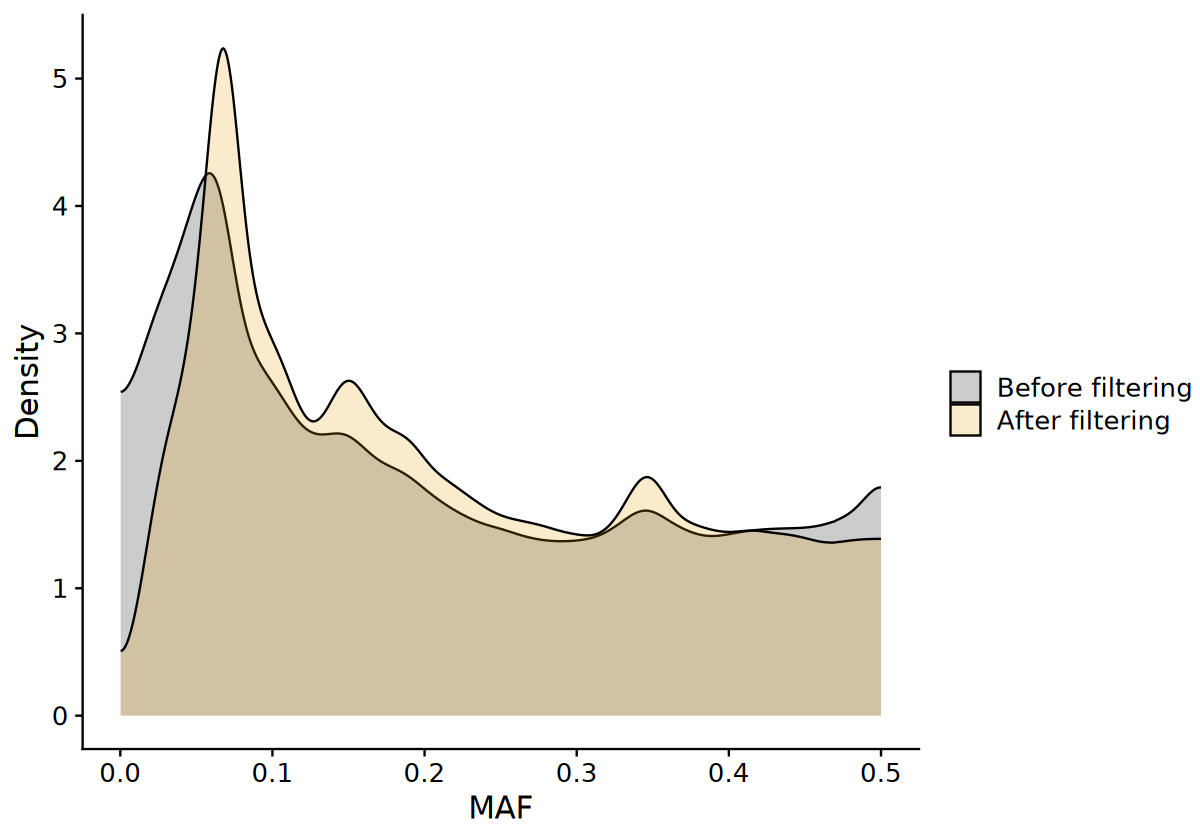

In [107]:
options(repr.plot.width = 10, repr.plot.height = 7)
figure_s5 <- ggplot(df, aes(x = maf, fill = as.factor(iteration))) +
    geom_density(alpha = 0.2, bounds = c(0, 0.5), bw = 0.01) +
    theme_cowplot(18) +
    scale_fill_manual(values = c("black", "#E69F00"), labels = c("1" = "Before filtering", "5" = "After filtering")) +
    labs(x = "MAF", y = "Density", fill = "")

figure_s5

In [108]:
ggsave(
    "/nfs/research/birney/users/saul/outputs/heart_rate_tmp/stitch_downsampling/draft_figures/figure_s5_maf_distribution.pdf",
    figure_s5,
    width = 10,
    height = 7
)

# Figure S6 - Effect of filtering on strain distribution

In [2]:
setwd("/nfs/research/birney/users/saul/outputs/heart_rate_tmp/f1_f2/stitchimpute/K16_nGen2_downsampled_truth_stitch_downsampling_snps/manual_maf_by_cross/")

In [3]:
snp_freq1 <- fread(cmd = "zstdcat iteration_1.afreq.zst")[, iteration := 1]

In [4]:
snp_freq5 <- fread(cmd = "zstdcat iteration_5.afreq.zst")[, iteration := 5]

In [5]:
snps_to_drop <- rbind(snp_freq1, snp_freq5)[
    , maf := ifelse(ALT_FREQS > 0.5, 1 - ALT_FREQS, ALT_FREQS)
][
    maf == 0, .(ID, iteration)
]

In [6]:
f_list <- list.files(pattern = "iteration_.*.\".*\".afreq.zst")
f_list

[1] "iteration_1.\"139-4x55-2\".afreq.zst"
 [2] "iteration_1.\"139-4x72-2\".afreq.zst"
 [3] "iteration_1.\"15-1x62-2\".afreq.zst" 
 [4] "iteration_1.\"15-1x72-2\".afreq.zst" 
 [5] "iteration_1.\"22-1x72-2\".afreq.zst" 
 [6] "iteration_1.\"55-2x72-2\".afreq.zst" 
 [7] "iteration_1.\"62-2x72-2\".afreq.zst" 
 [8] "iteration_1.\"68-1x72-2\".afreq.zst" 
 [9] "iteration_1.\"68-1x79-2\".afreq.zst" 
[10] "iteration_1.\"72-2x79-2\".afreq.zst" 
[11] "iteration_5.\"139-4x55-2\".afreq.zst"
[12] "iteration_5.\"139-4x72-2\".afreq.zst"
[13] "iteration_5.\"15-1x62-2\".afreq.zst" 
[14] "iteration_5.\"15-1x72-2\".afreq.zst" 
[15] "iteration_5.\"22-1x72-2\".afreq.zst" 
[16] "iteration_5.\"55-2x72-2\".afreq.zst" 
[17] "iteration_5.\"62-2x72-2\".afreq.zst" 
[18] "iteration_5.\"68-1x72-2\".afreq.zst" 
[19] "iteration_5.\"68-1x79-2\".afreq.zst" 
[20] "iteration_5.\"72-2x79-2\".afreq.zst"

In [7]:
read_freq <- function(f){
    df <- fread(cmd = sprintf("zstdcat '%s'", f))
    df[, iteration := f |> str_remove("iteration_") |> str_remove("\\..*") |> as.numeric()]
    df[, cross_id := f |> str_remove(".afreq.zst") |> str_remove("iteration_..\"") |> str_remove("\"")]
    return(df)
}

In [8]:
df_cross_raw <- lapply(f_list, read_freq) |> rbindlist()

In [9]:
nrow(df_cross_raw)/1e6

[1] 97.1156

In [10]:
df_cross <- df_cross_raw[!snps_to_drop, on = c("ID", "iteration")]

In [11]:
nrow(df_cross)/1e6

[1] 82.30342

In [12]:
maf_df <- df_cross[
    !is.na(ALT_FREQS), .(maf = ifelse(ALT_FREQS > 0.5, 1 - ALT_FREQS, ALT_FREQS), cross_id, ID, iteration)
]

In [13]:
crosses_per_snp <- maf_df[
    , pass := maf > 0.4
][
    , .(n_crosses = sum(pass)), by = c("ID", "iteration")
][
    , .(n = .N), by = c("iteration", "n_crosses")
][
    , .(p = n/sum(n)*100, n_crosses), by = c("iteration")
]

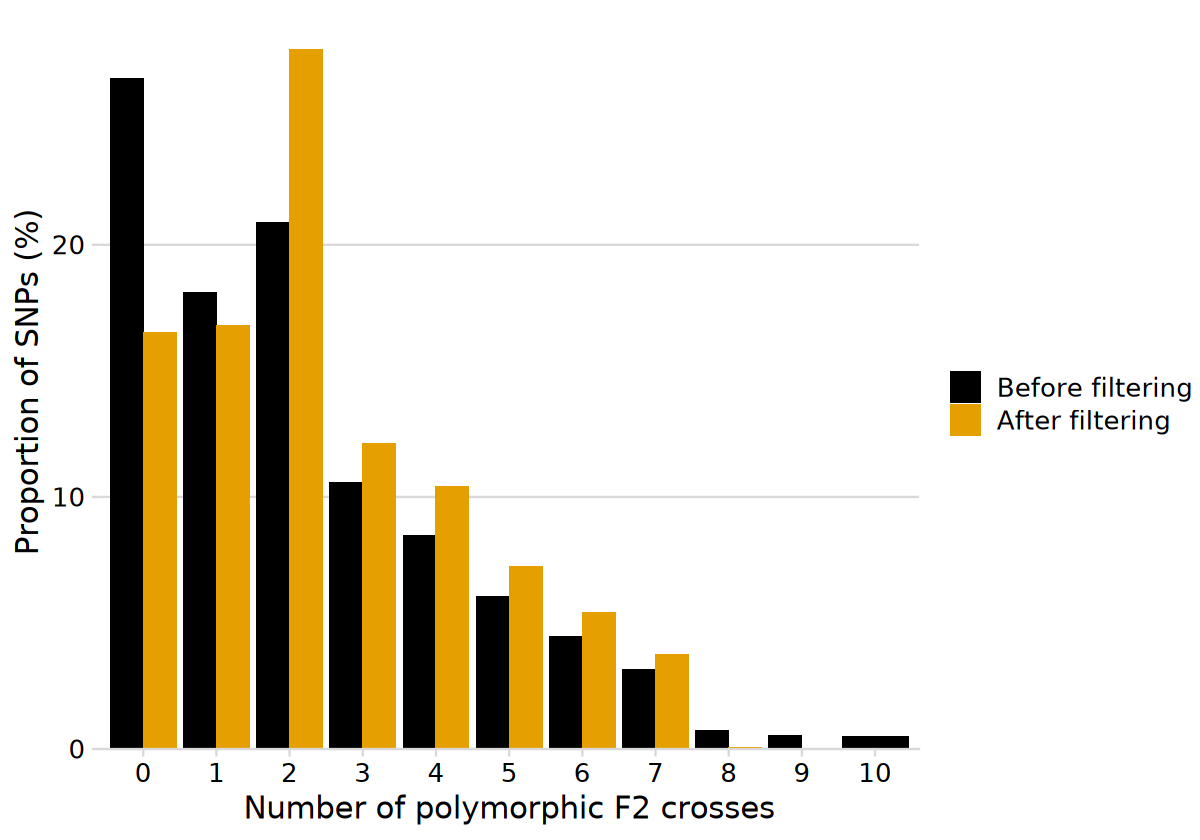

In [14]:
options(repr.plot.width = 10, repr.plot.height = 7)
figure_s6 <- ggplot(crosses_per_snp, aes(x = as.factor(n_crosses), y = p, fill = as.factor(iteration))) +
    geom_bar(position = "dodge", stat = "identity") +
    scale_fill_manual(values = c("black", "#E69F00"), labels = c("1" = "Before filtering", "5" = "After filtering")) +
    labs(x = "Number of polymorphic F2 crosses", y = "Proportion of SNPs (%)", fill = "") +
    theme_minimal_hgrid(18) +
    scale_y_continuous(expand = expansion(mult = c(0, 0.05)))

figure_s6

In [16]:
ggsave(
    "/nfs/research/birney/users/saul/outputs/heart_rate_tmp/stitch_downsampling/draft_figures/figure_s6_polymorphic_crosses.pdf",
    figure_s6,
    width = 10,
    height = 7
)